### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import namedtuple
from scipy.signal import butter, filtfilt
from scipy.io import loadmat
from collections import namedtuple
from math import floor
from scipy import stats
import antropy as ant
import spkit as sp
import seaborn as sns
import EntropyHub as En

import pywt
import warnings
from vmdpy import VMD
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

### Read and preprocess data

In [2]:
EEG_78_CH2 = pd.read_csv('EEG_78_CH2.csv')
bis_78 = pd.read_csv('bis_78.csv')
B78=bis_78['BIS/BIS']
E78=EEG_78_CH2['BIS/EEG2_WAV']
print ('The shape of EEG signals and BIS for patient 78 is {} and {} '.format(E78.shape,B78.shape) )
print ('The type of EEG signals and BIS for patient 78 is {} and {} '.format(type(E78),type(B78)) )

The shape of EEG signals and BIS for patient 78 is (535191,) and (4180,) 
The type of EEG signals and BIS for patient 78 is <class 'pandas.core.series.Series'> and <class 'pandas.core.series.Series'> 


In [3]:
#checking for missing values

def missing_values(eeg_signal):

    # Check for missing values
    missing_values = np.isnan(eeg_signal)
    length_signals = len(eeg_signal)

    # Count the number of missing values
    num_missing_values = np.sum(missing_values)
    percentage_missing_values = (num_missing_values/length_signals)*100

    # Print the indices and values of missing values
    missing_indices = np.where(missing_values)[0]
    missing_values_list = eeg_signal[missing_indices]

    print("Missing Values:")
    print(f"Total Missing Values: {num_missing_values}")
    print(f"Percentage of Missing Values: {percentage_missing_values} %")  
missing_values(E78)

Missing Values:
Total Missing Values: 167
Percentage of Missing Values: 0.03120381321808476 %


In [4]:
E78_copy = np.copy(E78)

In [5]:
# Handling missing values

def handle_missing_values(signal):
    # Interpolate missing values using linear interpolation
    mask = np.isnan(signal)
    signal[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), signal[~mask])
    return signal
E78_copy=handle_missing_values(E78_copy)

### Selecting EEG signals

In [6]:
import numpy as np

# Assuming BIS and EEG are numpy arrays
BIS = B78
EEG = E78_copy

# Define the sampling frequency
fs = 128

# Define the indices for BIS range from 200 to 800
bis_start_index = 200
bis_end_index = 800

# Convert the BIS indices to EEG indices

eeg_start_index = bis_start_index * fs
eeg_end_index = bis_end_index * fs

# Select EEG values for BIS[200:800]
selected_EEG = EEG[eeg_start_index:eeg_end_index]
selected_bis = BIS[bis_start_index:bis_end_index]
selected_bis = np.array(selected_bis)
print(selected_EEG)


[-14.8  -12.6  -13.1  ... -21.3  -21.8  -20.45]


### Bandpass filtering

In [7]:
# Define the EEG signal
eeg_signal = selected_EEG # Replace with your actual EEG signal


# Define the filter function
def bandpass_filter(signal, lowcut, highcut, fs, order=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# time in seconds
time = np.arange(len(eeg_signal)) / fs

# Apply bandpass filters to the EEG signal
bpass = bandpass_filter(eeg_signal, 0.01, 63.5, fs=128)


### Variational Mode Decomposition (VMD)

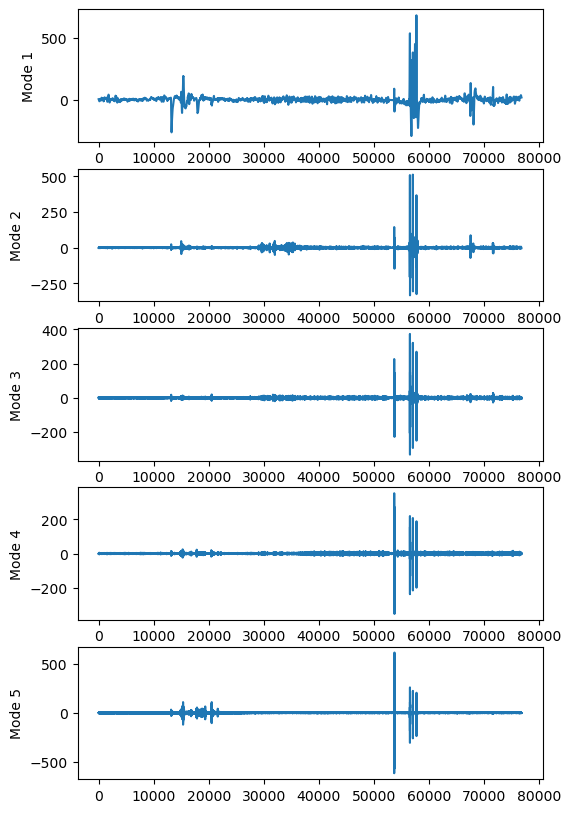

In [8]:


import numpy as np
from vmdpy import VMD

signal = bpass

# Set VMD parameters
alpha = 2000
tau = 0.5
K = 5
DC = 0
init = 1           # initialize omegas uniformly  
tol = 1e-7 

# Run VMD on the signal
modes, spectrum, omega =VMD (signal, alpha, tau, K, DC, init,tol)

#Plot the decomposed modes
import matplotlib.pyplot as plt
fig, axs = plt.subplots(K, 1, figsize=(6, 10))
for i in range(K):
    axs[i].plot(modes[i, :])
    axs[i].set_ylabel(f"Mode {i+1}")
plt.show()

### Windowing and features extraction

Number of BIS: 545


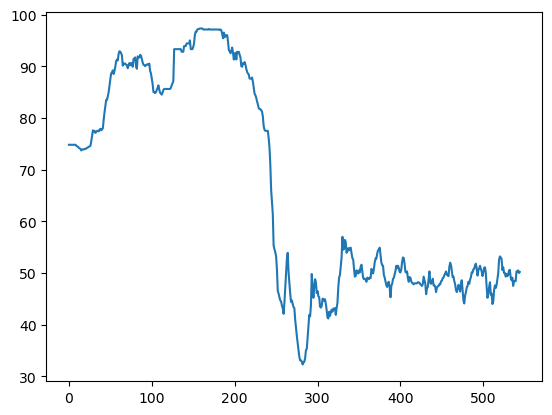

In [9]:
# For BIS

def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    windows = []

    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end][0]
        windows.append(window)

    return windows

# Example usage
data = selected_bis  # Sample data
window_size_sec = 56.0       # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 1         # Sampling rate in samples per second

# Apply moving sliding window
bis_windows = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate)

# Print the number of windows and the shape of the first window
print("Number of BIS:", len(bis_windows))
plt.plot(bis_windows)
plt.show()


In [10]:
# For mean and standard deviation

def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    
    windows = []
    
    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end]
        windows.append(window)
        #window_start += stride
        
        
        if method == "mean":
            # Calculate sample entropy within the window
            results = np.mean(windows, axis=1)
            


        if method == "std":
            # Calculate sample entropy within the window
            results = np.std(windows, axis=1)

    return results

In [11]:
# Example usage
data0 = modes[0] 
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
results_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='mean')
results_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='mean')
results_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='mean')
results_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='mean')
results_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='mean')
print(f"Number of features:", len(results_0))

Number of features: 545


Number of features: 545


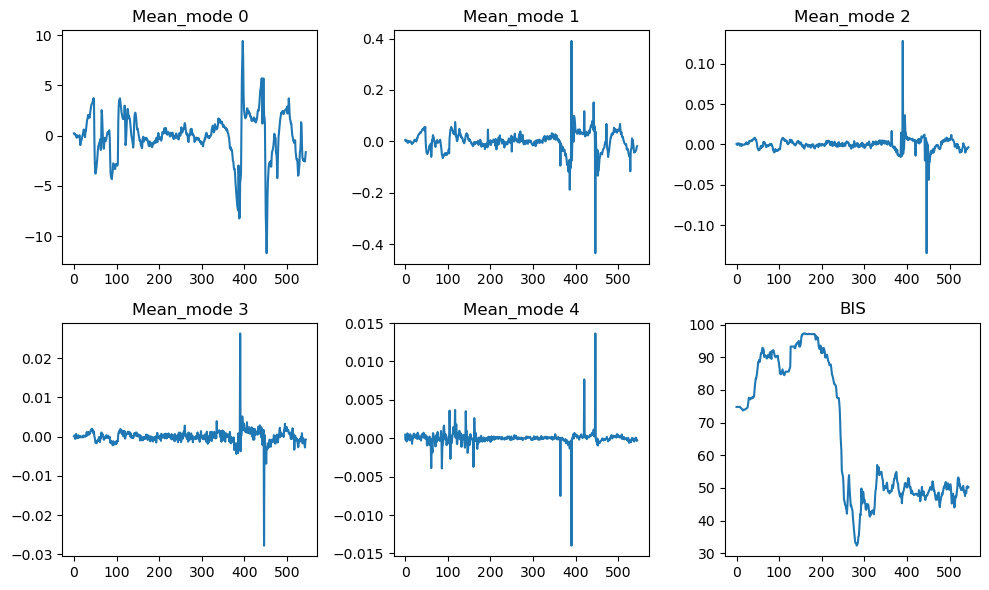

In [12]:
print(f"Number of features:", len(results_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(results_0)
axes[0, 0].set_title('Mean_mode 0')

# Plot on the second subplot
axes[0, 1].plot(results_1)
axes[0, 1].set_title('Mean_mode 1')

# Plot on the third subplot
axes[0, 2].plot(results_2)
axes[0, 2].set_title('Mean_mode 2')

axes[1, 0].plot(results_3)
axes[1, 0].set_title('Mean_mode 3')

axes[1, 1].plot(results_4)
axes[1, 1].set_title('Mean_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


In [13]:
# Example usage
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]


# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
result_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='std')
result_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='std')
result_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='std')
result_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='std')
result_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='std')
    
print(f"Number of features:", len(result_0))

Number of features: 545


Number of features: 545


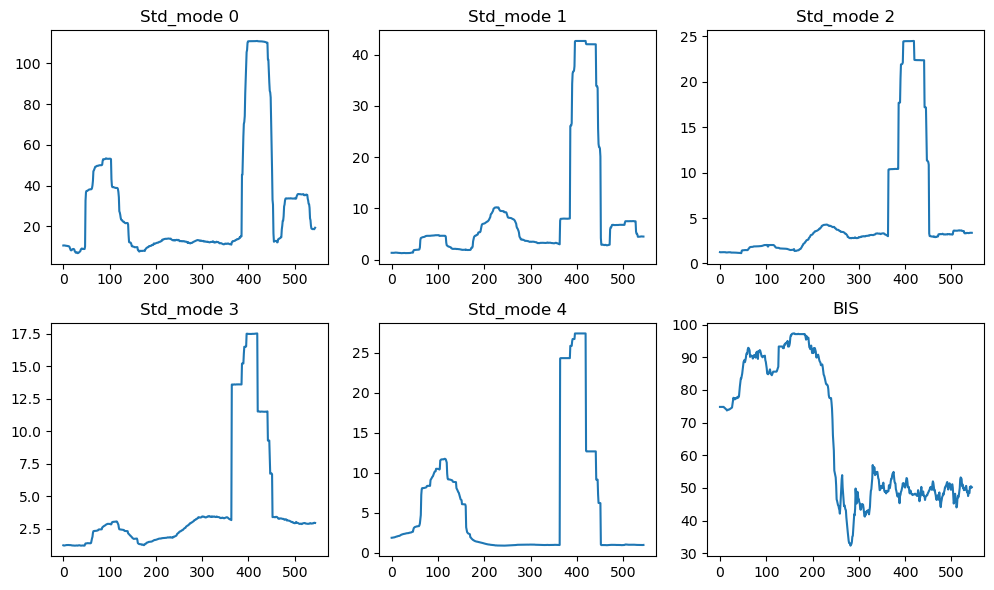

In [14]:
print(f"Number of features:", len(result_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(result_0)
axes[0, 0].set_title('Std_mode 0')

# Plot on the second subplot
axes[0, 1].plot(result_1)
axes[0, 1].set_title('Std_mode 1')

# Plot on the third subplot
axes[0, 2].plot(result_2)
axes[0, 2].set_title('Std_mode 2')

axes[1, 0].plot(result_3)
axes[1, 0].set_title('Std_mode 3')

axes[1, 1].plot(result_4)
axes[1, 1].set_title('Std_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


In [12]:
#### For entropies

def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    
    result = []
    
    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end]
        
        
        if method == "sample entropy":
            # Calculate sample entropy within the window
            sample_entropy = ant.sample_entropy(window)
            result.append(sample_entropy)


        if method == "Permutation entropy":
            # Calculate sample entropy within the window
            permutation_entropy = ant.perm_entropy(window)
            result.append(permutation_entropy)
            
        if method == "Dispersion entropy":
            # Calculate sample entropy within the window
            Dispersion_entropy, prob = sp.dispersion_entropy(window,classes=5, scale=3, emb_dim=3, delay=1,return_all=False)
            result.append(Dispersion_entropy)

    return result


In [13]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128 


resultsa_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='sample entropy')
resultsa_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='sample entropy')
resultsa_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='sample entropy')
resultsa_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='sample entropy')
resultsa_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='sample entropy')
print(f"Number of features:", len(resultsa_0))



TypeError: argument of type 'builtin_function_or_method' is not iterable

Number of features: 545


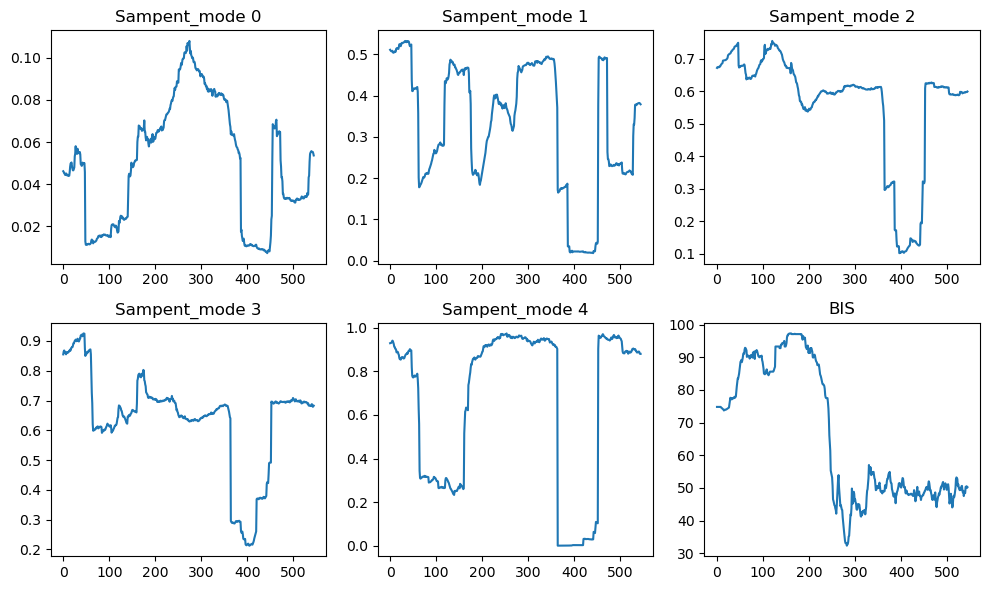

In [17]:
print(f"Number of features:", len(result_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsa_0)
axes[0, 0].set_title('Sampent_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsa_1)
axes[0, 1].set_title('Sampent_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsa_2)
axes[0, 2].set_title('Sampent_mode 2')

axes[1, 0].plot(resultsa_3)
axes[1, 0].set_title('Sampent_mode 3')

axes[1, 1].plot(resultsa_4)
axes[1, 1].set_title('Sampent_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


In [18]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128        # Sampling rate in samples per second


# Apply moving sliding window and calculate sample entropies
resultsp_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')
resultsp_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')
resultsp_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')
resultsp_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')
resultsp_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')

print(f"Number of features:", len(resultsp_0))


Number of features: 545


Number of features: 545


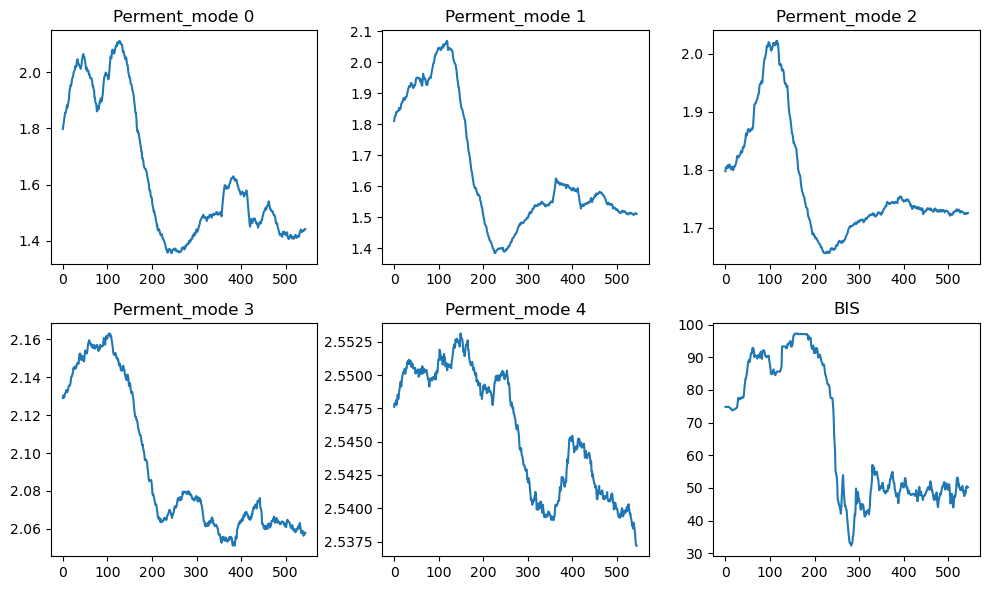

In [19]:
print(f"Number of features:", len(result_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsp_0)
axes[0, 0].set_title('Perment_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsp_1)
axes[0, 1].set_title('Perment_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsp_2)
axes[0, 2].set_title('Perment_mode 2')

axes[1, 0].plot(resultsp_3)
axes[1, 0].set_title('Perment_mode 3')

axes[1, 1].plot(resultsp_4)
axes[1, 1].set_title('Perment_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


In [20]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128        # Sampling rate in samples per second

# Apply moving sliding window and calculate sample entropies
resultsd_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
resultsd_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
resultsd_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
resultsd_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
resultsd_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
print(f"Number of features:", len(resultsd_0))


Number of features: 545


Number of features: 545


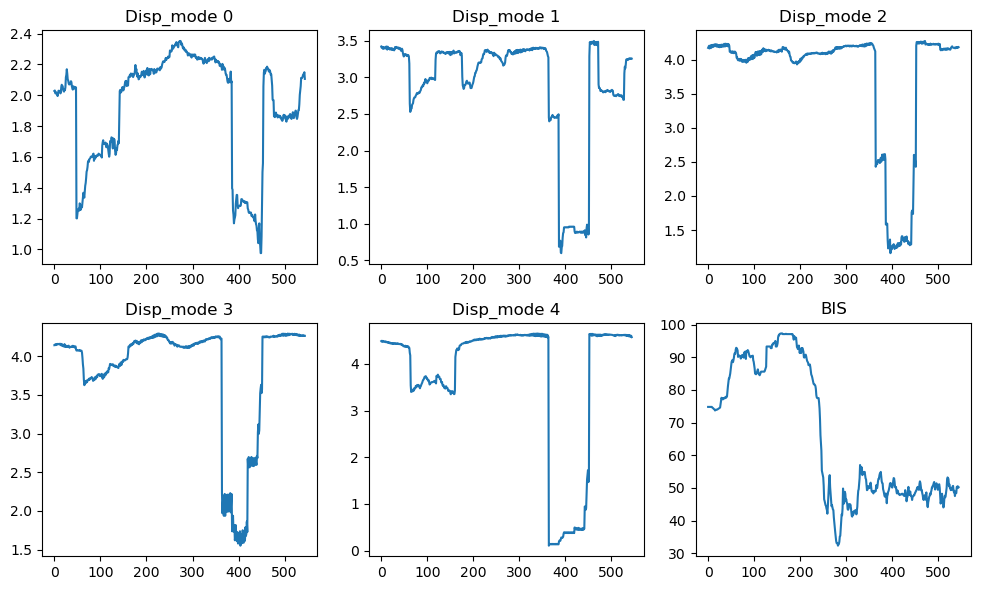

In [21]:
print(f"Number of features:", len(result_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsd_0)
axes[0, 0].set_title('Disp_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsd_1)
axes[0, 1].set_title('Disp_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsd_2)
axes[0, 2].set_title('Disp_mode 2')

axes[1, 0].plot(resultsd_3)
axes[1, 0].set_title('Disp_mode 3')

axes[1, 1].plot(resultsd_4)
axes[1, 1].set_title('Disp_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


### Create Dataframe for each feature and find the correlation


In [38]:
# Mean

df_mean = pd.DataFrame({'Mean_mode0': results_0, 'Mean_mode1': results_1, 'Mean_mode2': results_2, 'Mean_mode3': results_3, 'Mean_mode4': results_4})

df_mean['BIS']=bis_windows
df_mean


Mean_mode0  Mean_mode1  Mean_mode2  Mean_mode3  Mean_mode4   BIS
0      0.232257    0.005220    0.000557    0.000095    0.000464  74.8
1      0.126812    0.000836   -0.000298    0.000328   -0.000230  74.8
2      0.163526    0.002878    0.001149    0.000173    0.000334  74.8
3      0.154706    0.000231   -0.000018   -0.000562   -0.000424  74.8
4      0.100866    0.003390    0.001203    0.000155   -0.000318  74.8
..          ...         ...         ...         ...         ...   ...
540   -2.375188   -0.040123   -0.006236   -0.000817   -0.000238  50.3
541   -2.400029   -0.035847   -0.005046   -0.002078    0.000079  50.3
542   -2.576705   -0.032501   -0.004982   -0.002753   -0.000030  50.5
543   -2.030931   -0.021898   -0.003891   -0.001063   -0.000342  50.0
544   -1.641064   -0.018725   -0.003414   -0.000744   -0.000306  50.2

[545 rows x 6 columns]

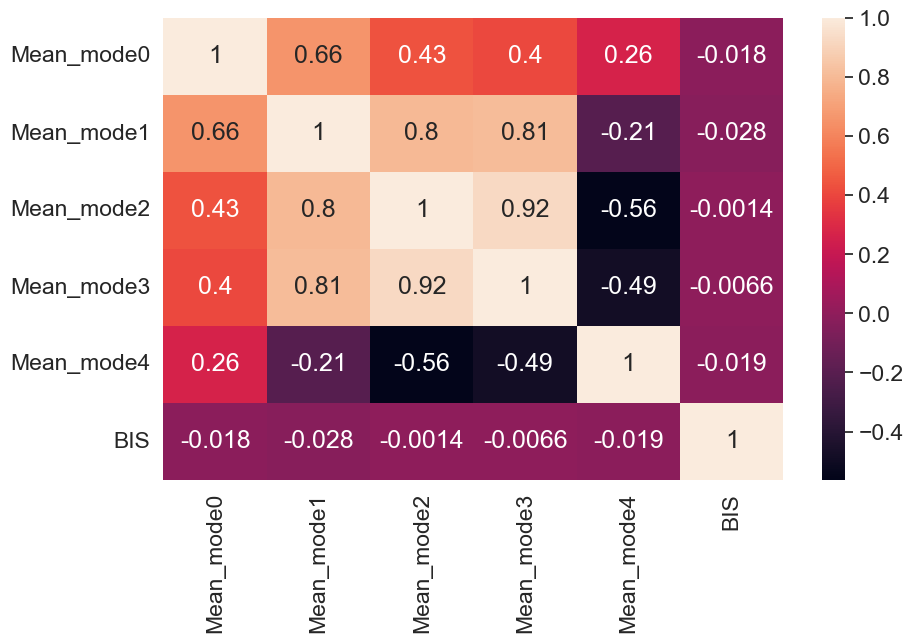

In [39]:
plt.figure(figsize=(10,6))
sns.heatmap(df_mean.corr(), annot = True)
plt.show()

In [40]:
# Standard deviation

df_std = pd.DataFrame({'Std_mode0': result_0, 'Std_mode1': result_1, 'Std_mode2': result_2, 'Std_mode3': result_3, 'Std_mode4': result_4})

df_std['BIS']=bis_windows
df_std

Std_mode0  Std_mode1  Std_mode2  Std_mode3  Std_mode4   BIS
0    10.675966   1.326040   1.248807   1.206860   1.876188  74.8
1    10.722019   1.323680   1.234726   1.193107   1.880030  74.8
2    10.674937   1.323047   1.237488   1.189003   1.889676  74.8
3    10.671724   1.324311   1.239843   1.196984   1.904244  74.8
4    10.657654   1.326581   1.248872   1.205170   1.918594  74.8
..         ...        ...        ...        ...        ...   ...
540  18.785702   4.522085   3.380887   2.894759   0.959952  50.3
541  18.786433   4.521532   3.379534   2.918514   0.960294  50.3
542  18.638363   4.516118   3.385783   2.947022   0.969709  50.5
543  18.980588   4.505123   3.381020   2.938022   0.969581  50.0
544  19.377203   4.497277   3.378241   2.932306   0.978673  50.2

[545 rows x 6 columns]

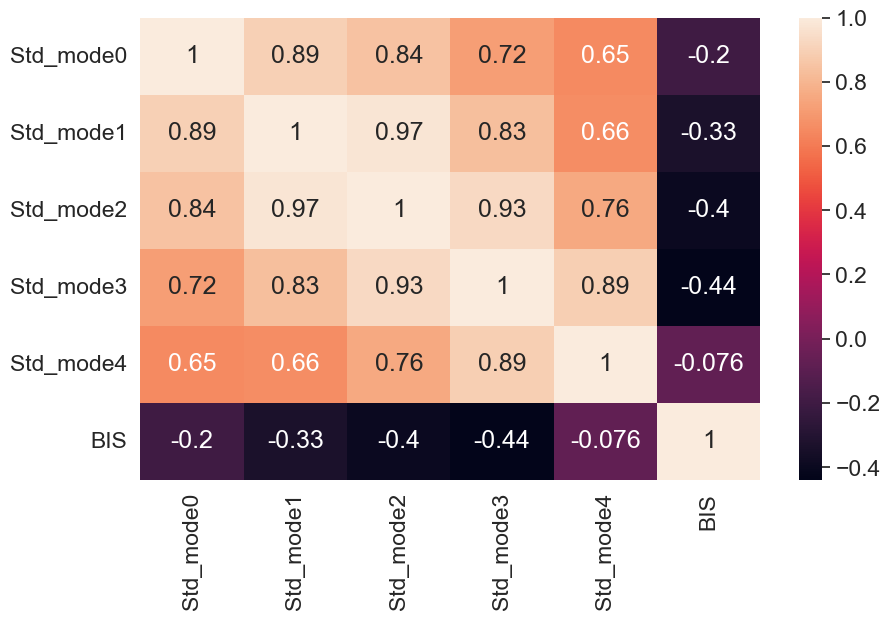

In [41]:
plt.figure(figsize=(10,6))
sns.heatmap(df_std.corr(), annot = True)
plt.show()

In [42]:
# Sample entropy

df_samp = pd.DataFrame({'Sampent_mode0': resultsa_0, 'Sampent_mode1': resultsa_1, 'Sampent_mode2': resultsa_2, 'Sampent_mode3': resultsa_3, 'Sampent_mode4': resultsa_4})

df_samp['BIS']=bis_windows
df_samp

Sampent_mode0  Sampent_mode1  Sampent_mode2  Sampent_mode3  \
0         0.046131       0.510747       0.672575       0.855030   
1         0.045788       0.509160       0.674919       0.864634   
2         0.045170       0.507674       0.674845       0.868143   
3         0.045059       0.507243       0.675302       0.864874   
4         0.044420       0.507155       0.674160       0.859561   
..             ...            ...            ...            ...   
540       0.055325       0.381418       0.597250       0.687904   
541       0.055267       0.382091       0.598295       0.682242   
542       0.055271       0.381479       0.598670       0.678945   
543       0.054599       0.379802       0.598116       0.680252   
544       0.053618       0.378722       0.599693       0.682899   

     Sampent_mode4   BIS  
0         0.929032  74.8  
1         0.929916  74.8  
2         0.931165  74.8  
3         0.931203  74.8  
4         0.936693  74.8  
..             ...   ...  
540       0.891075  50.3  
541       0.889180  50.3  
542       0.882266  50.5  
543       0.879855  50.0  
544       0.880069  50.2  

[545 rows x 6 columns]

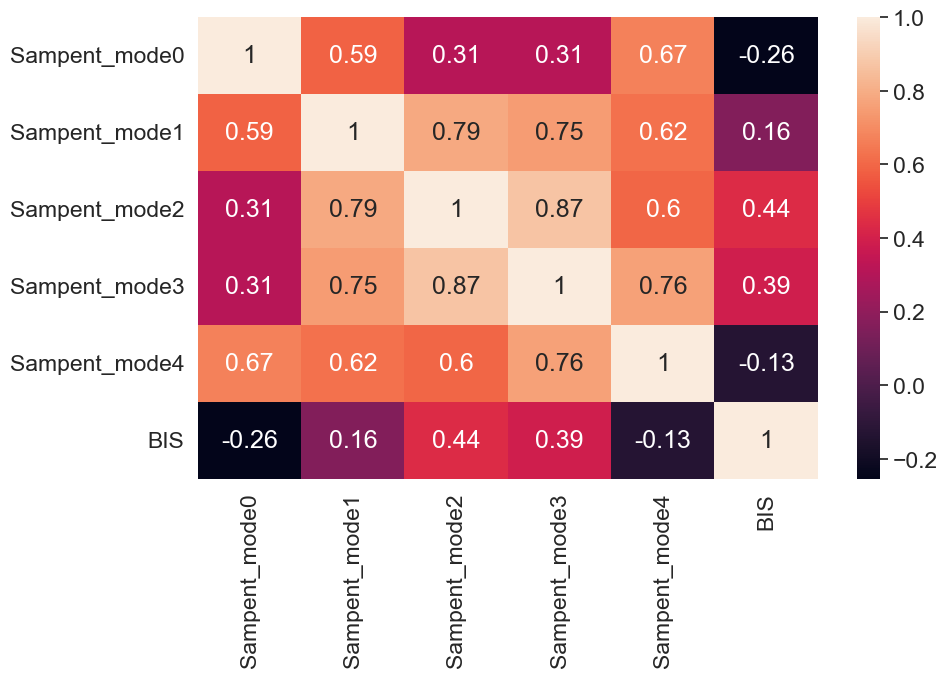

In [43]:
plt.figure(figsize=(10,6))
sns.heatmap(df_samp.corr(), annot = True)
plt.show()

In [44]:
# Permutation entropy

df_perm = pd.DataFrame({'Perment_mode0': resultsp_0, 'Perment_mode1': resultsp_1, 'Perment_mode2': resultsp_2, 'Perment_mode3': resultsp_3, 'Perment_mode4': resultsp_4})

df_perm['BIS']=bis_windows
df_perm

Perment_mode0  Perment_mode1  Perment_mode2  Perment_mode3  \
0         1.798433       1.809763       1.797230       2.129083   
1         1.808978       1.819440       1.803821       2.130396   
2         1.820784       1.825496       1.803386       2.130260   
3         1.831453       1.825928       1.802937       2.129278   
4         1.843357       1.831445       1.804329       2.130636   
..             ...            ...            ...            ...   
540       1.438072       1.512021       1.724062       2.056356   
541       1.436332       1.510877       1.723560       2.056753   
542       1.440363       1.511016       1.724554       2.057464   
543       1.441754       1.511681       1.725596       2.058172   
544       1.441350       1.510355       1.725591       2.057741   

     Perment_mode4   BIS  
0         2.547615  74.8  
1         2.547877  74.8  
2         2.547743  74.8  
3         2.547883  74.8  
4         2.547783  74.8  
..             ...   ...  
540       2.538241  50.3  
541       2.537944  50.3  
542       2.537419  50.5  
543       2.537210  50.0  
544       2.537197  50.2  

[545 rows x 6 columns]

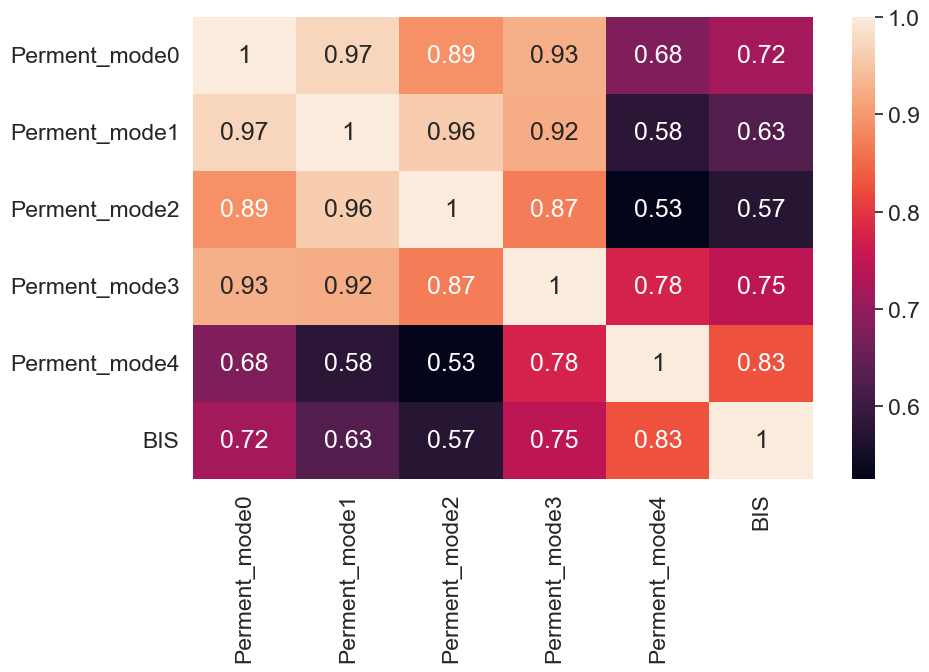

In [45]:
plt.figure(figsize=(10,6))
sns.heatmap(df_perm.corr(), annot = True)
plt.show()

In [46]:
# Dispersion entropy

df_disp = pd.DataFrame({'Disp_mode0': resultsd_0, 'Disp_mode1': resultsd_1, 'Disp_mode2': resultsd_2, 'Disp_mode3': resultsd_3, 'Disp_mode4': resultsd_4})

df_disp['BIS']=bis_windows
df_disp

Disp_mode0  Disp_mode1  Disp_mode2  Disp_mode3  Disp_mode4   BIS
0      2.028156    3.421405    4.175850    4.141072    4.486528  74.8
1      2.031229    3.404485    4.191805    4.142419    4.473938  74.8
2      2.013051    3.418159    4.206116    4.152833    4.480553  74.8
3      2.022015    3.409464    4.166973    4.141748    4.491303  74.8
4      2.010958    3.388967    4.197652    4.149643    4.472397  74.8
..          ...         ...         ...         ...         ...   ...
540    2.132369    3.253003    4.174007    4.264944    4.604187  50.3
541    2.137403    3.259977    4.182181    4.261484    4.580289  50.3
542    2.140553    3.257980    4.188612    4.267574    4.601510  50.5
543    2.149871    3.251499    4.179432    4.260852    4.597759  50.0
544    2.106427    3.255278    4.185752    4.261454    4.571174  50.2

[545 rows x 6 columns]

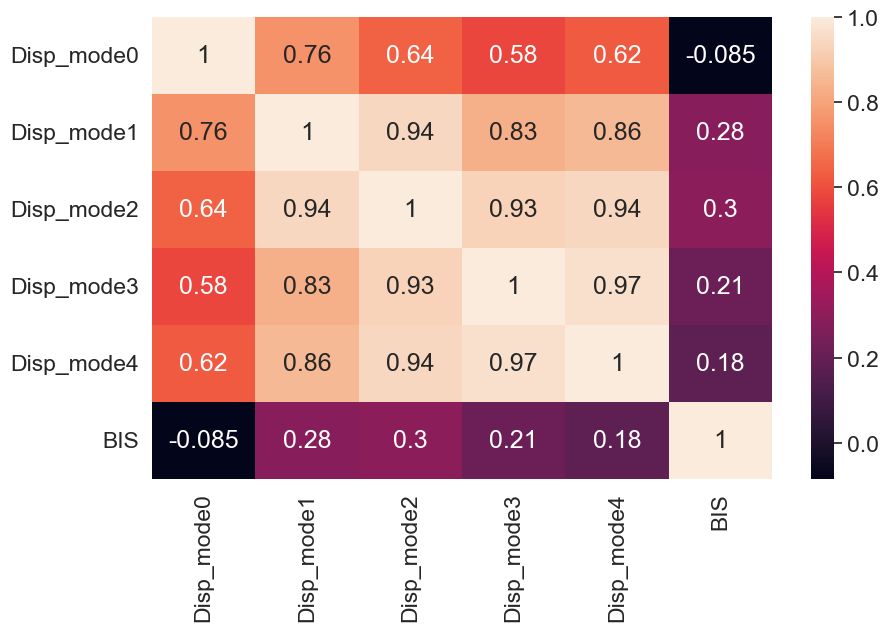

In [47]:
plt.figure(figsize=(10,6))
sns.heatmap(df_disp.corr(), annot = True)
plt.show()

In [48]:
df_me = pd.DataFrame({'Mean_mode0': results_0, 'Mean_mode1': results_1, 'Mean_mode2': results_2, 'Mean_mode3': results_3, 'Mean_mode4': results_4})
df_st = pd.DataFrame({'Std_mode0': result_0, 'Std_mode1': result_1, 'Std_mode2': result_2, 'Std_mode3': result_3, 'Std_mode4': result_4})
df_sa = pd.DataFrame({'Sampent_mode0': resultsa_0, 'Sampent_mode1': resultsa_1, 'Sampent_mode2': resultsa_2, 'Sampent_mode3': resultsa_3, 'Sampent_mode4': resultsa_4})
df_pe = pd.DataFrame({'Perment_mode0': resultsp_0, 'Perment_mode1': resultsp_1, 'Perment_mode2': resultsp_2, 'Perment_mode3': resultsp_3, 'Perment_mode4': resultsp_4})

df=pd.concat([df_me, df_st, df_sa, df_pe], axis=1)
df['BIS']=bis_windows
df.head()





Mean_mode0  Mean_mode1  Mean_mode2  Mean_mode3  Mean_mode4  Std_mode0  \
0    0.232257    0.005220    0.000557    0.000095    0.000464  10.675966   
1    0.126812    0.000836   -0.000298    0.000328   -0.000230  10.722019   
2    0.163526    0.002878    0.001149    0.000173    0.000334  10.674937   
3    0.154706    0.000231   -0.000018   -0.000562   -0.000424  10.671724   
4    0.100866    0.003390    0.001203    0.000155   -0.000318  10.657654   

   Std_mode1  Std_mode2  Std_mode3  Std_mode4  ...  Sampent_mode1  \
0   1.326040   1.248807   1.206860   1.876188  ...       0.510747   
1   1.323680   1.234726   1.193107   1.880030  ...       0.509160   
2   1.323047   1.237488   1.189003   1.889676  ...       0.507674   
3   1.324311   1.239843   1.196984   1.904244  ...       0.507243   
4   1.326581   1.248872   1.205170   1.918594  ...       0.507155   

   Sampent_mode2  Sampent_mode3  Sampent_mode4  Perment_mode0  Perment_mode1  \
0       0.672575       0.855030       0.929032       1.798433       1.809763   
1       0.674919       0.864634       0.929916       1.808978       1.819440   
2       0.674845       0.868143       0.931165       1.820784       1.825496   
3       0.675302       0.864874       0.931203       1.831453       1.825928   
4       0.674160       0.859561       0.936693       1.843357       1.831445   

   Perment_mode2  Perment_mode3  Perment_mode4   BIS  
0       1.797230       2.129083       2.547615  74.8  
1       1.803821       2.130396       2.547877  74.8  
2       1.803386       2.130260       2.547743  74.8  
3       1.802937       2.129278       2.547883  74.8  
4       1.804329       2.130636       2.547783  74.8  

[5 rows x 21 columns]

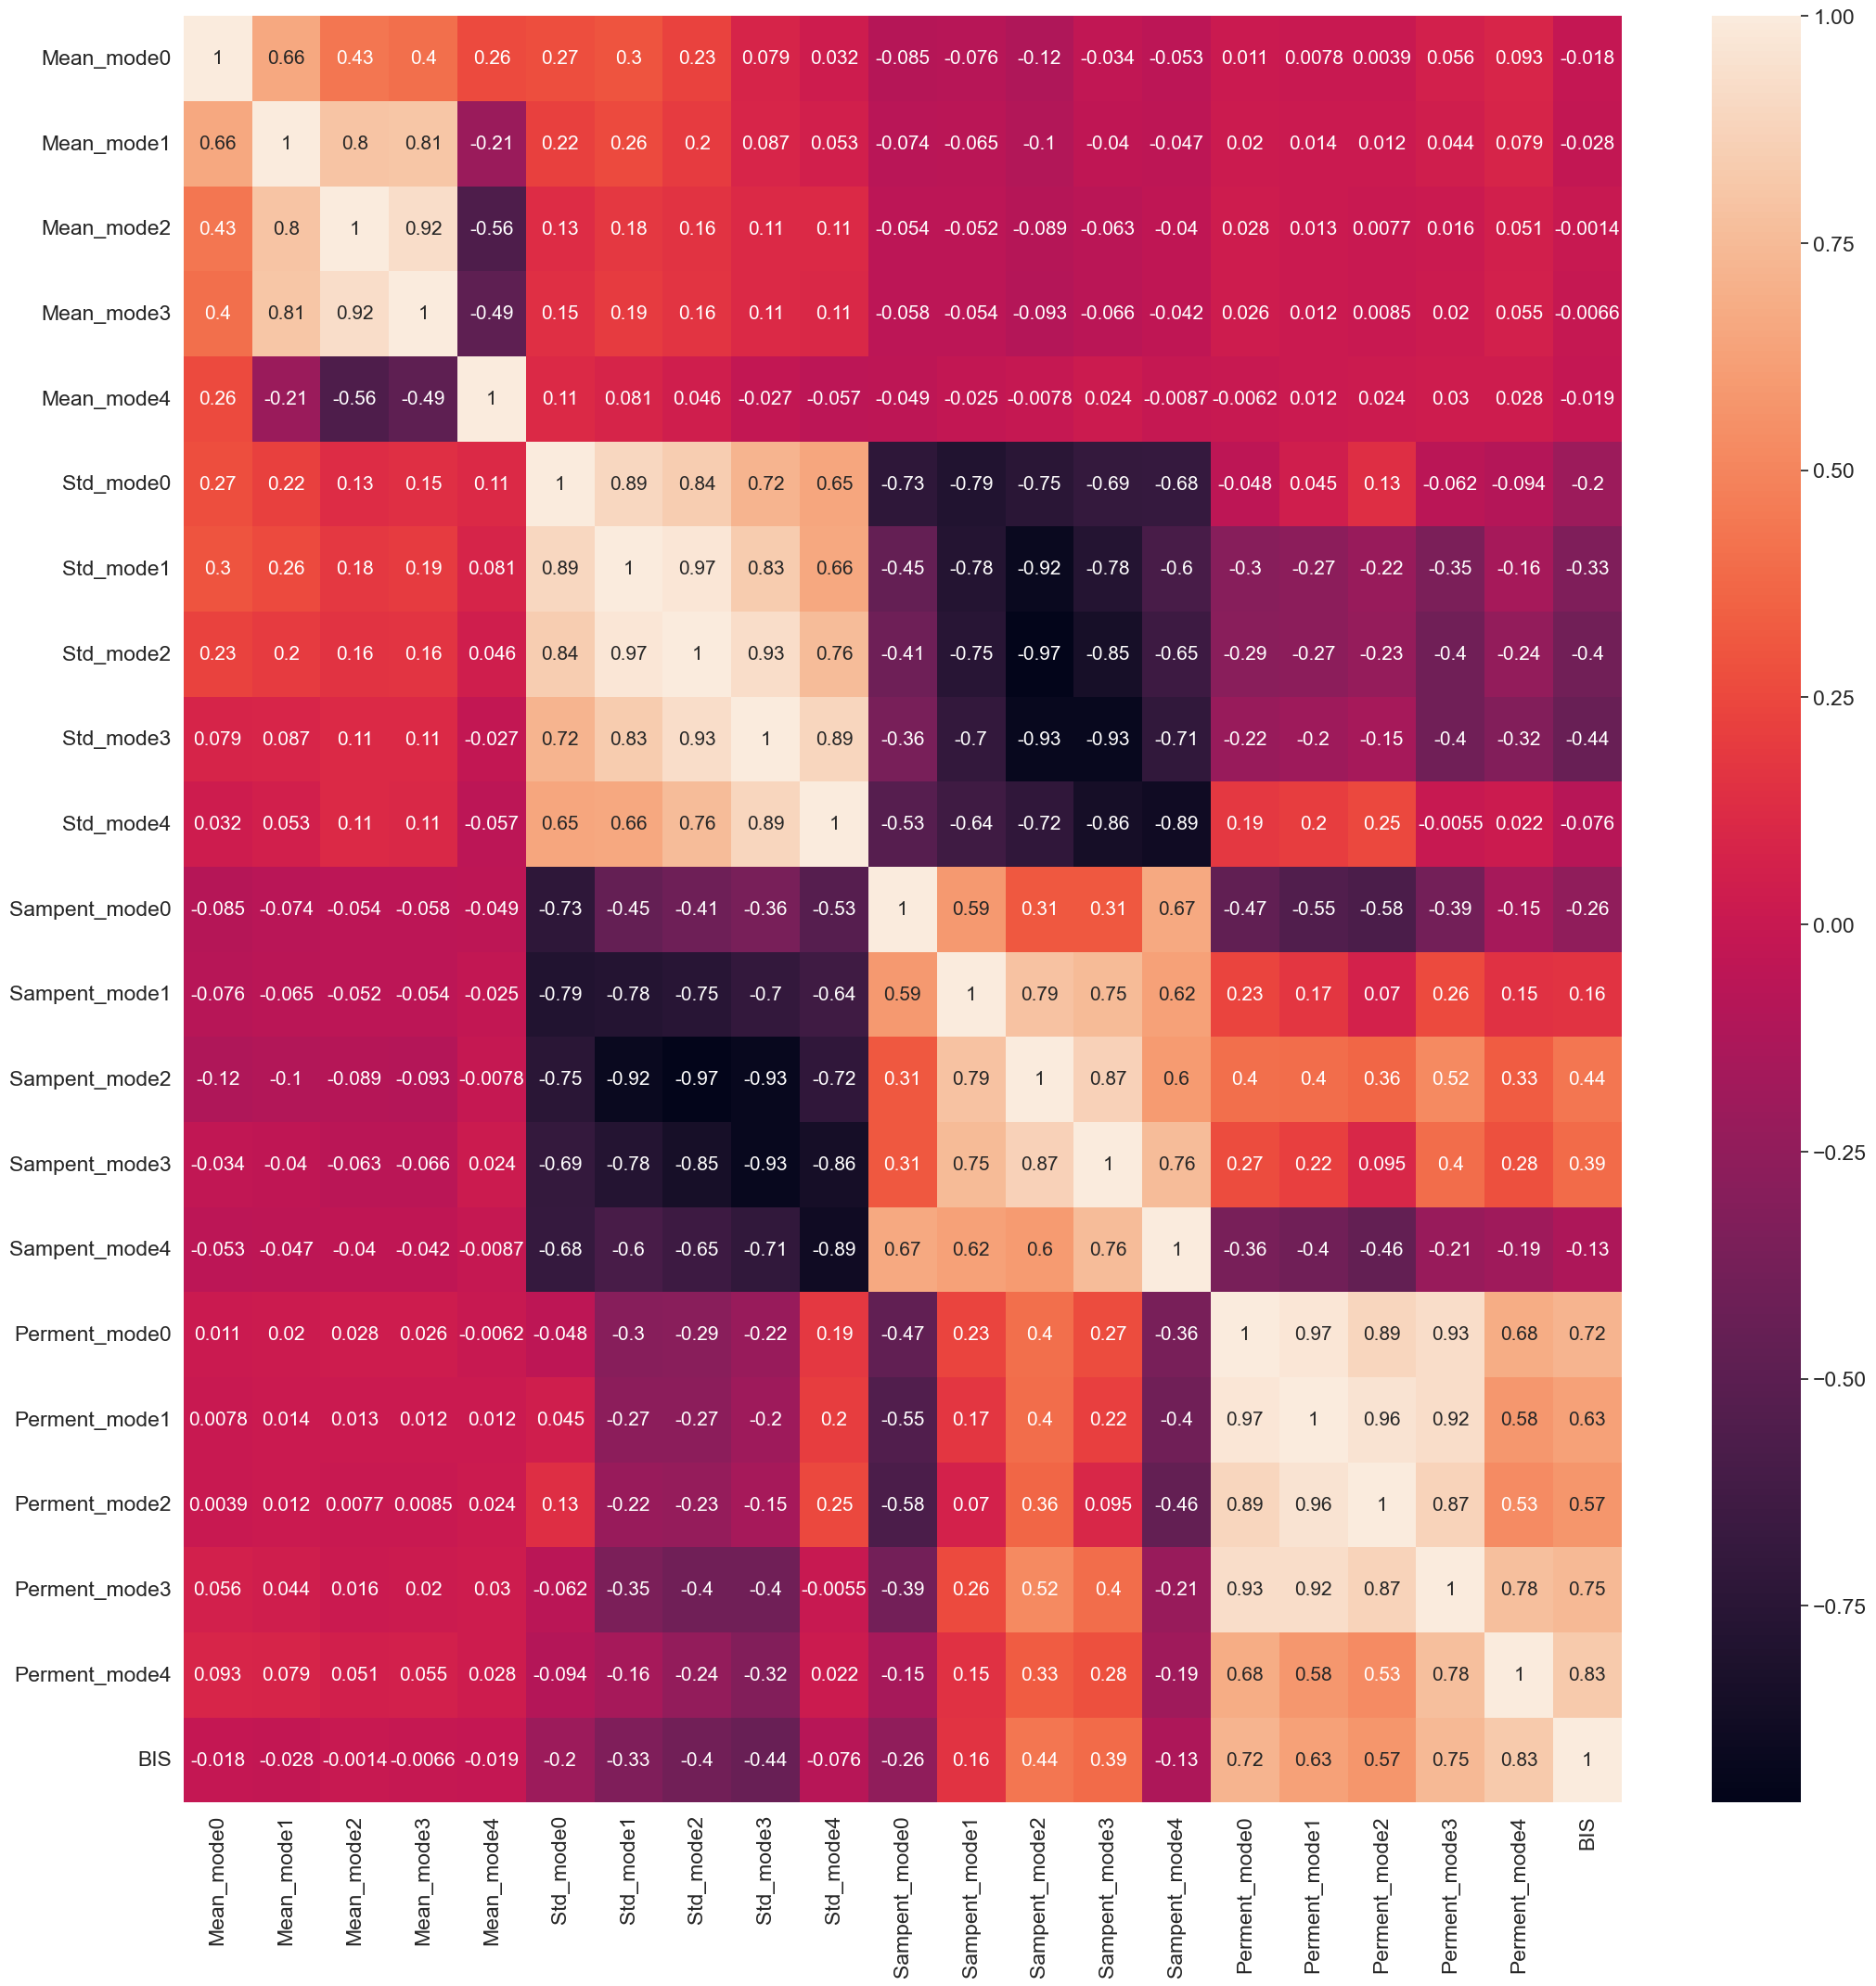

In [49]:
plt.figure(figsize=(25,25))
sns.heatmap(df.corr(), annot = True, annot_kws={'size' : 15})
sns.set(font_scale=1.5)
plt.show()

In [50]:
metrics = {}
def plot_regression(data, column, normalize=False):
    
    global metrics
    
    X = data[column].values.reshape(-1, 1)
    #X = X[:, np.newaxis]
    y = data['BIS']

    # Perform regression
    reg = LinearRegression(n_jobs=-1).fit(X, y)
    
    # Predictions
    y_predicted = reg.predict(X)
    
    # Show the score and r2
    #mse = mean_squared_error(y, y_predicted)
    r2 = r2_score(y, y_predicted)
    
    # keep track of metrics
    
    #metrics["{}_mse".format(column)] = mse
    metrics["{}_r2".format(column)] = r2
    
    
    # Plot the graph
    plt.figure(figsize=(8,6))
    plt.scatter(data[column], data['BIS'], label="Data", c="steelblue")
    plt.plot(X, y_predicted, label="Regression", c="red")
    plt.xlabel(column)
    plt.ylabel('BIS')
    plt.legend(loc="upper left")
    plt.show()

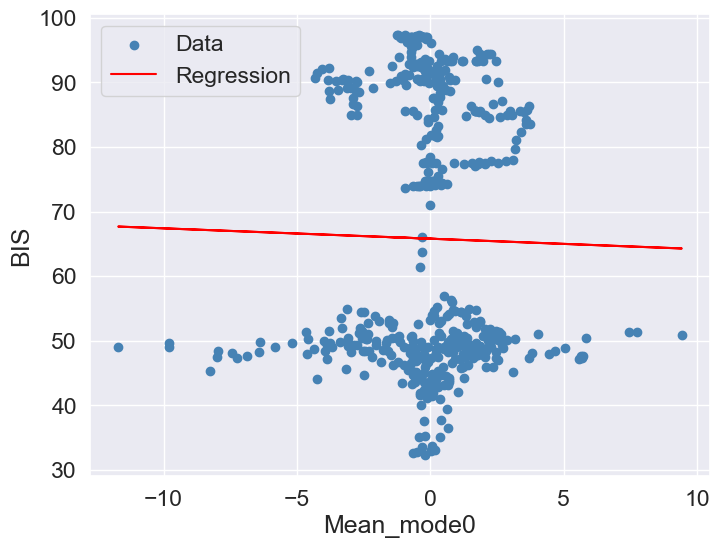

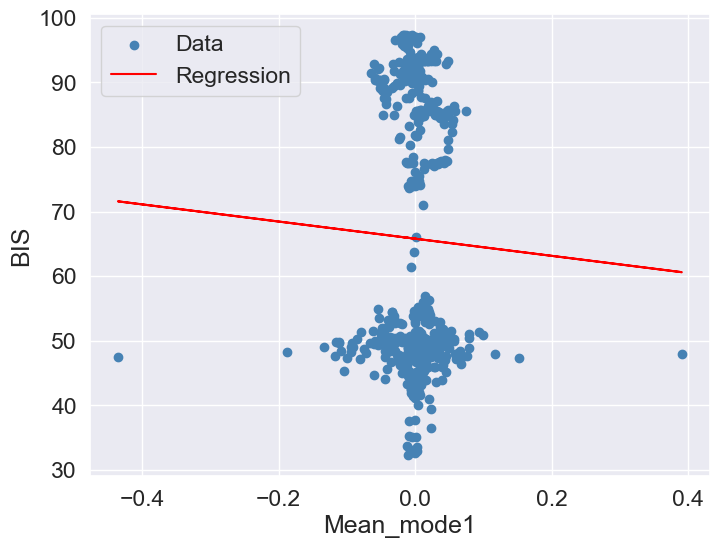

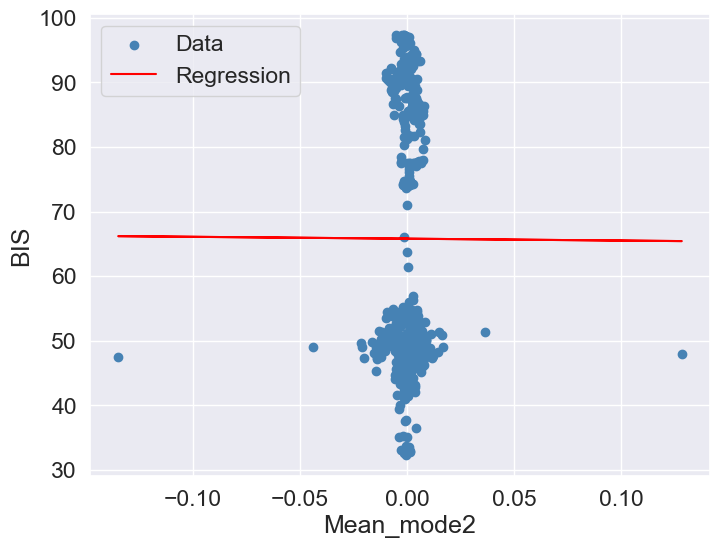

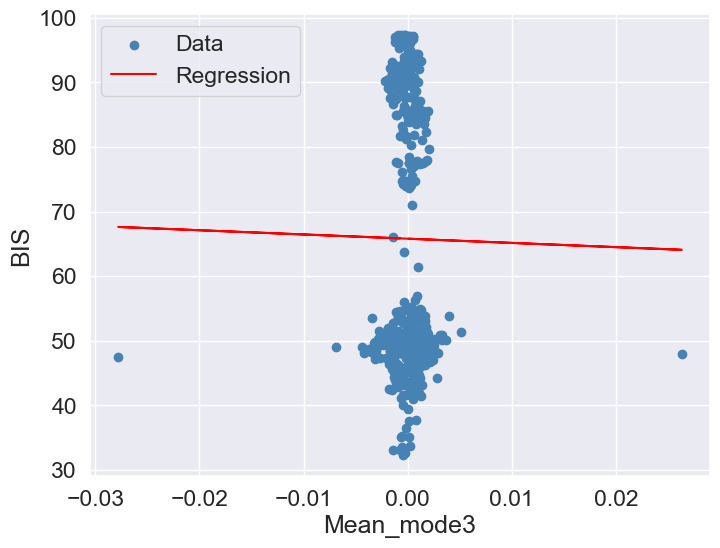

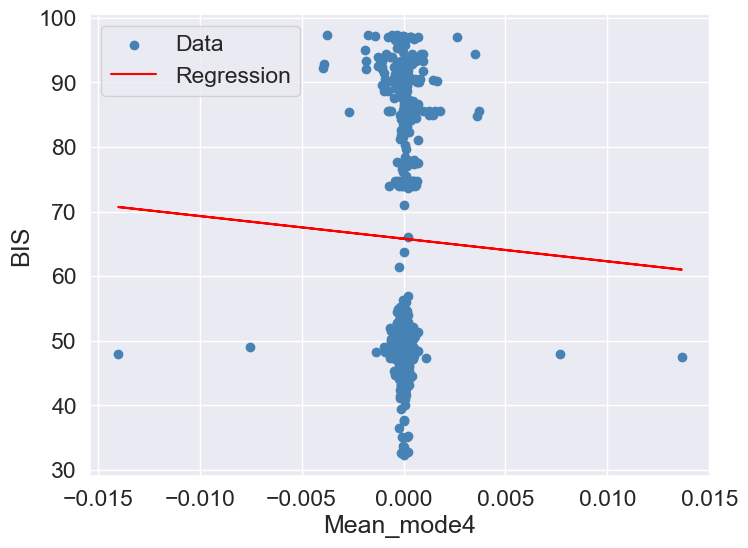

In [51]:
for column in df_mean.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_mean, column)

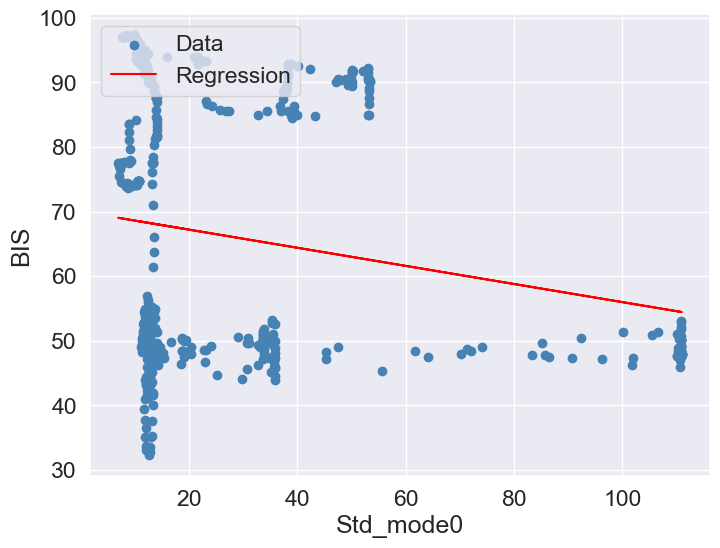

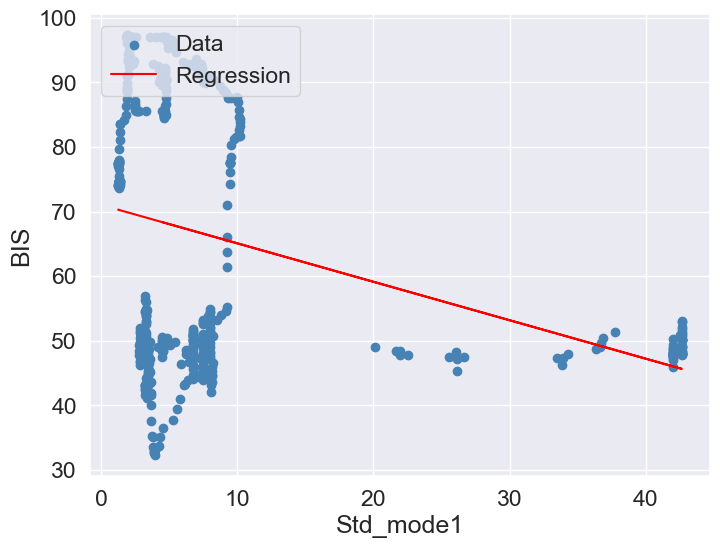

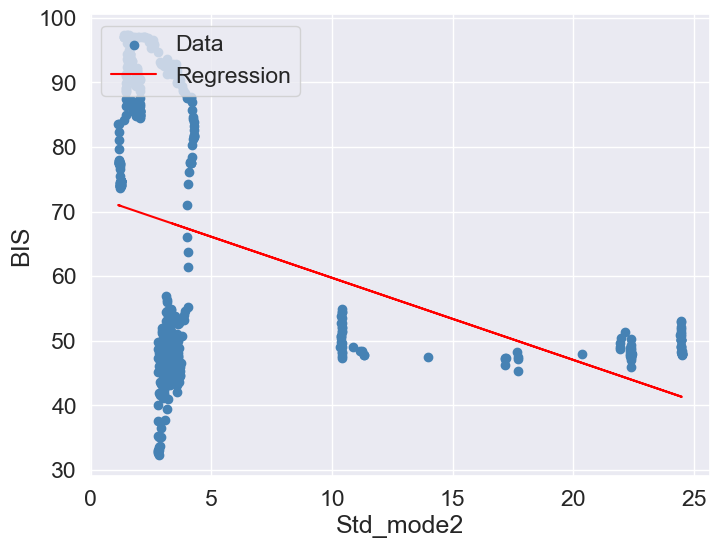

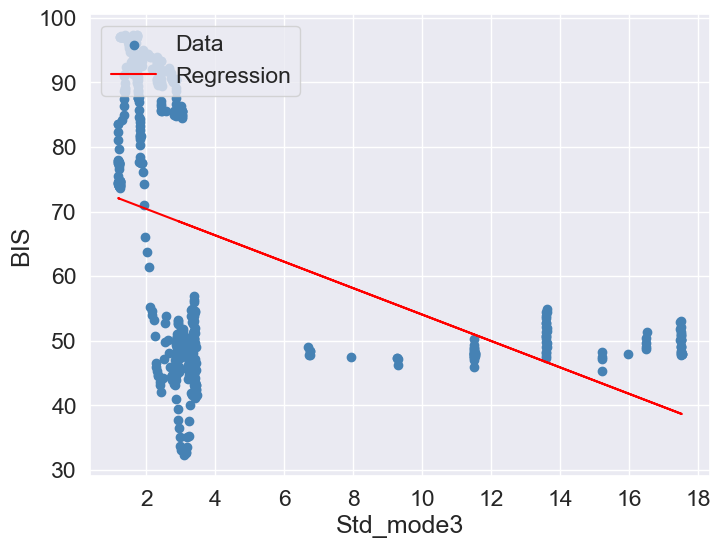

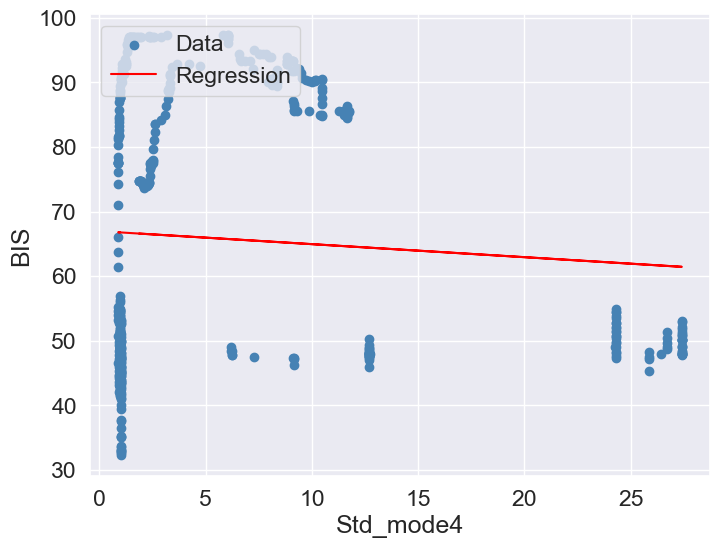

In [52]:
for column in df_std.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_std, column)

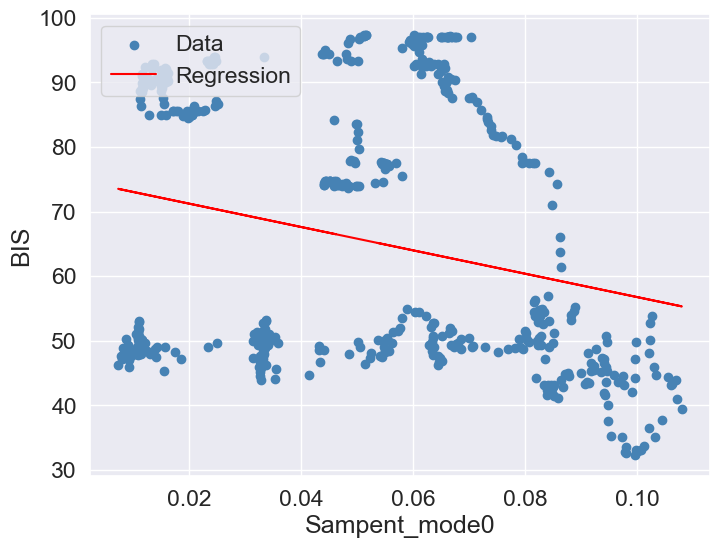

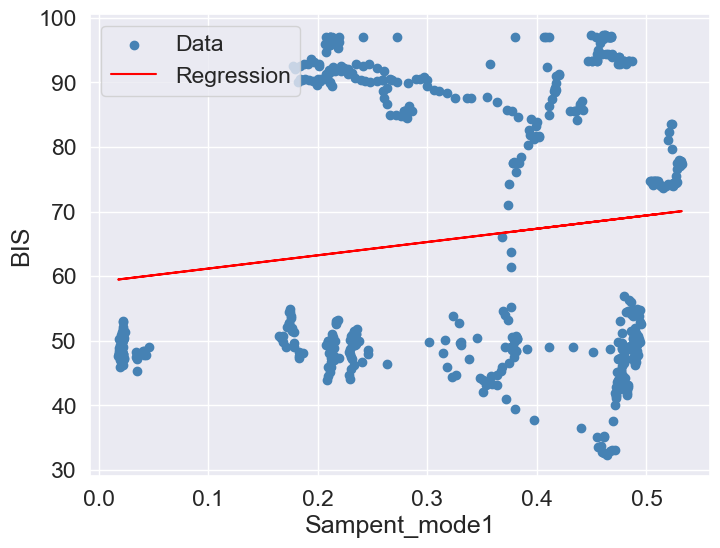

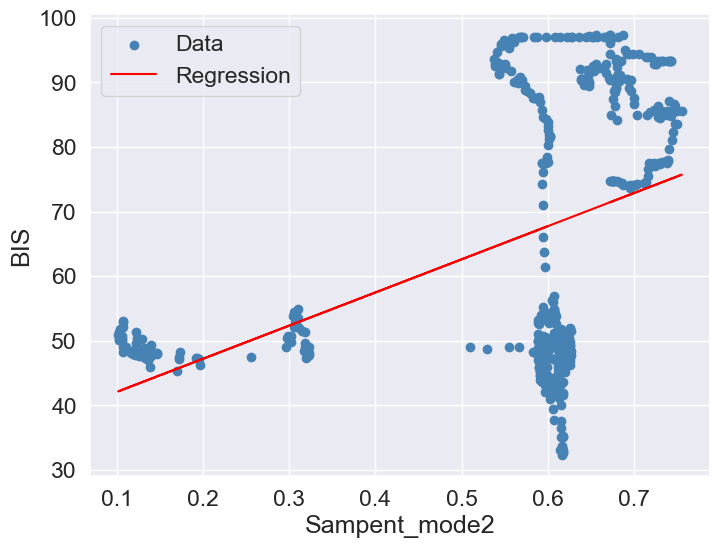

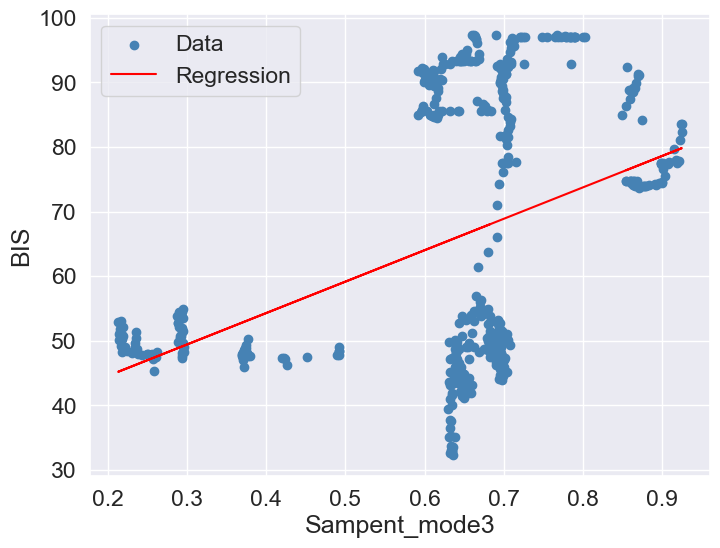

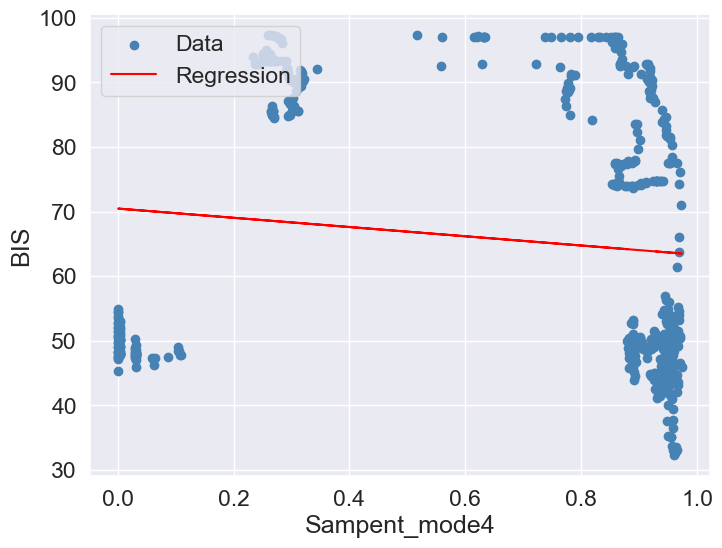

In [53]:
for column in df_samp.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_samp, column)

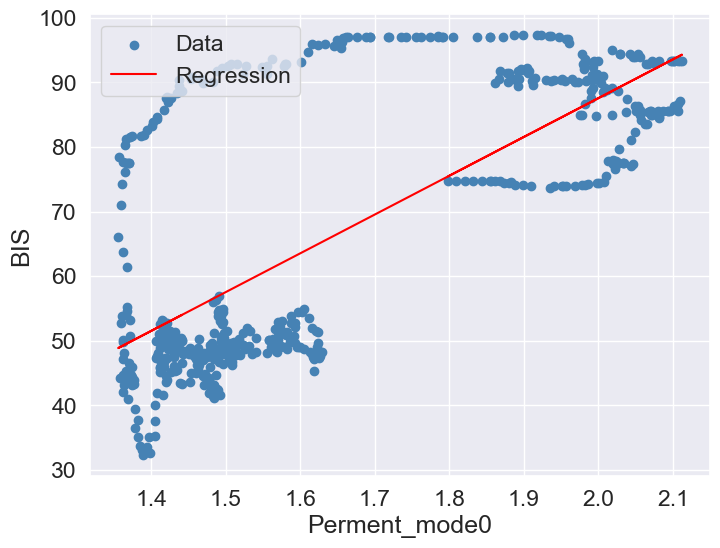

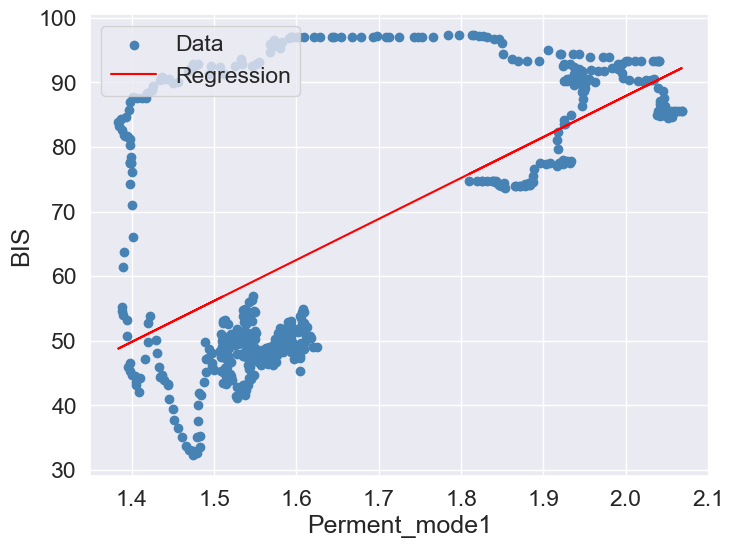

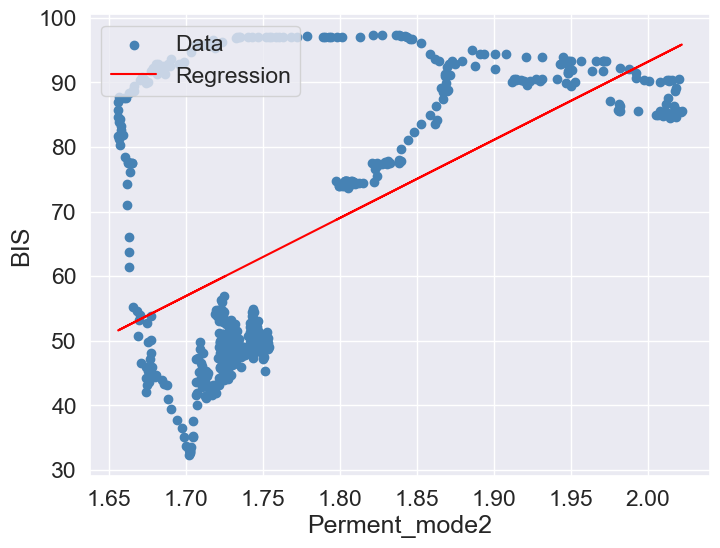

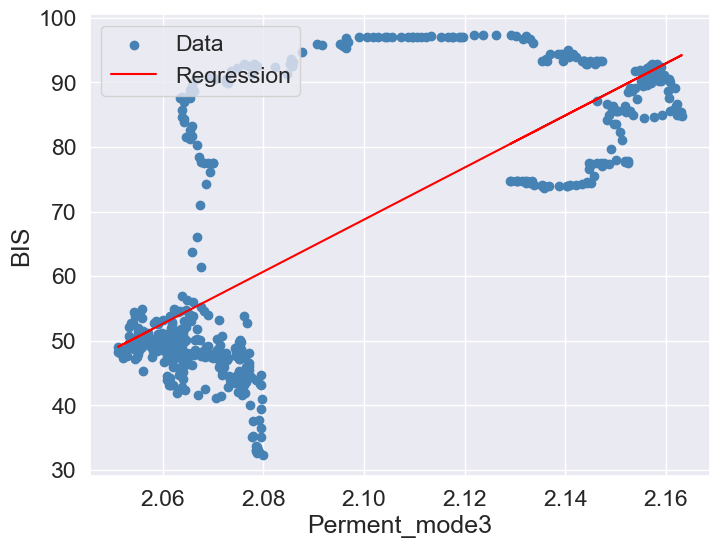

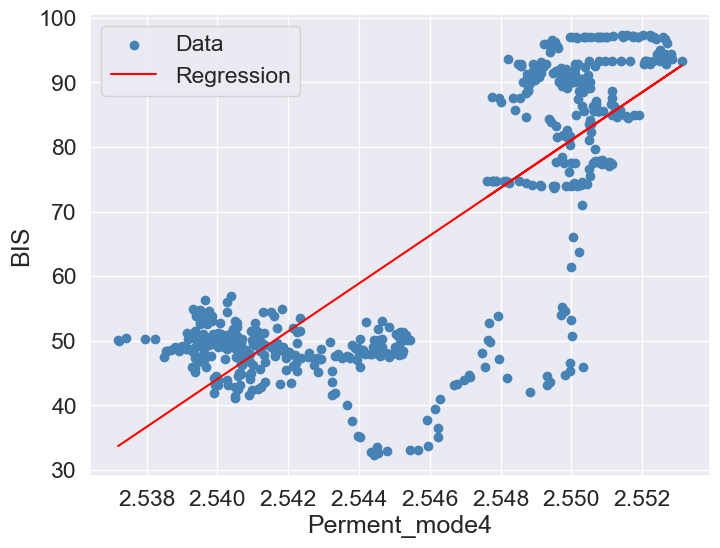

In [54]:
for column in df_perm.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_perm, column)
    
# Metrics
#pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value for value in metrics.values()]})

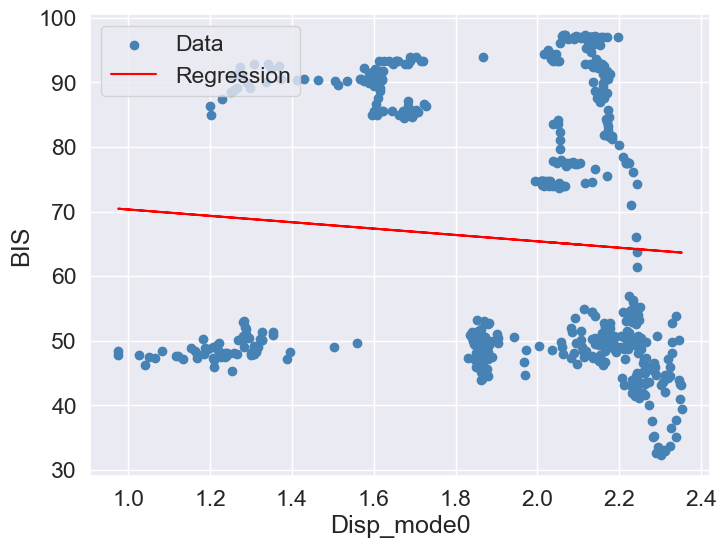

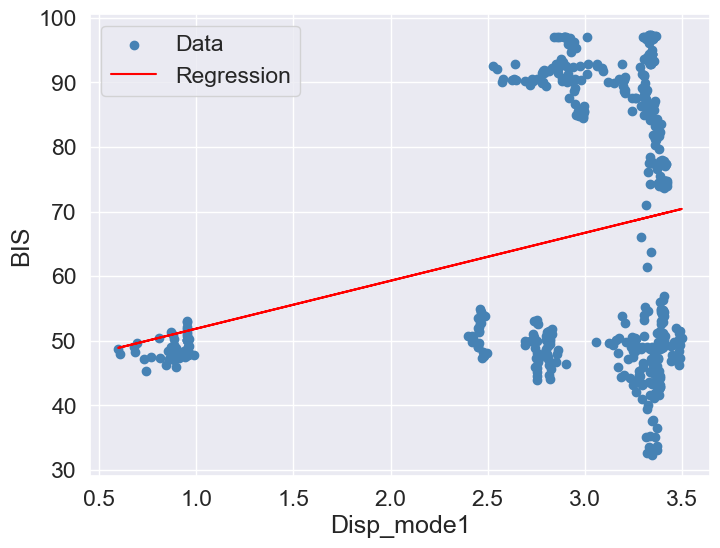

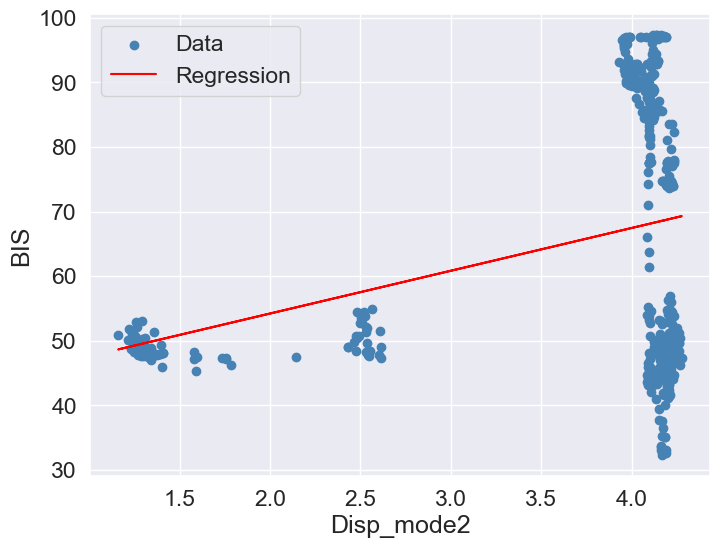

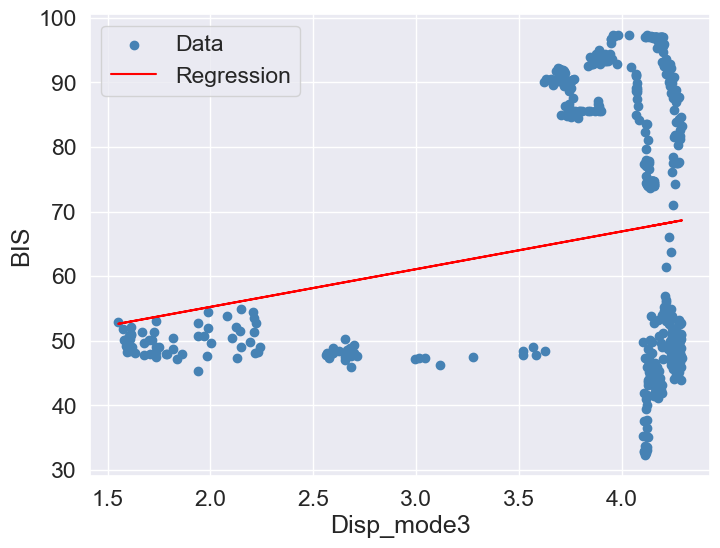

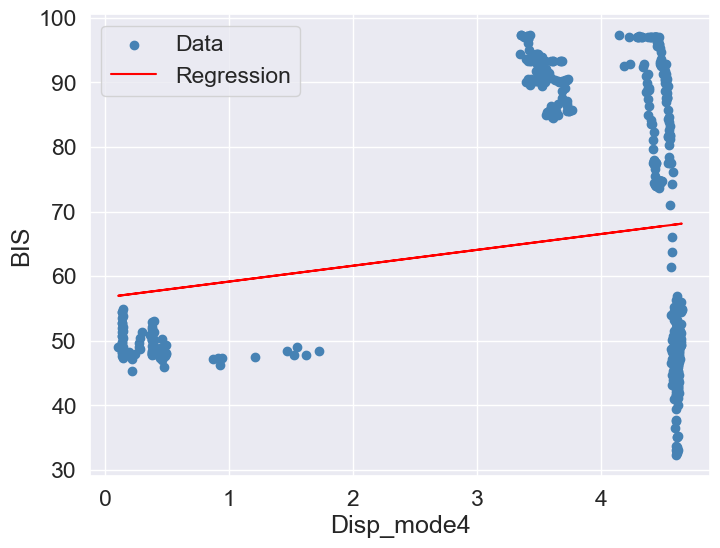

In [55]:
for column in df_disp.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_disp, column)
    
# Metrics
#pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value for value in metrics.values()]})

In [56]:
# Metrics
pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value for value in metrics.values()]})

Metrics    Values
0      Mean_mode0_r2  0.000310
1      Mean_mode1_r2  0.000767
2      Mean_mode2_r2  0.000002
3      Mean_mode3_r2  0.000043
4      Mean_mode4_r2  0.000367
5       Std_mode0_r2  0.040770
6       Std_mode1_r2  0.111027
7       Std_mode2_r2  0.157587
8       Std_mode3_r2  0.192403
9       Std_mode4_r2  0.005751
10  Sampent_mode0_r2  0.065093
11  Sampent_mode1_r2  0.024901
12  Sampent_mode2_r2  0.190474
13  Sampent_mode3_r2  0.153414
14  Sampent_mode4_r2  0.016316
15  Perment_mode0_r2  0.517085
16  Perment_mode1_r2  0.395406
17  Perment_mode2_r2  0.329194
18  Perment_mode3_r2  0.556278
19  Perment_mode4_r2  0.686317
20     Disp_mode0_r2  0.007299
21     Disp_mode1_r2  0.080525
22     Disp_mode2_r2  0.088046
23     Disp_mode3_r2  0.045301
24     Disp_mode4_r2  0.031832

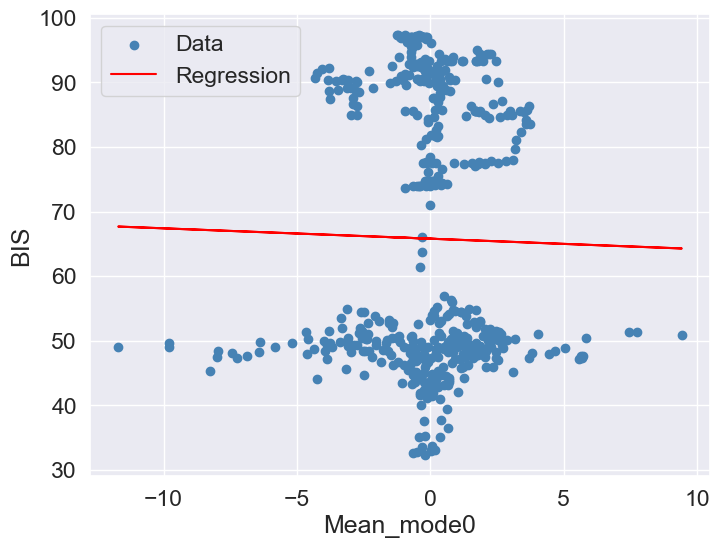

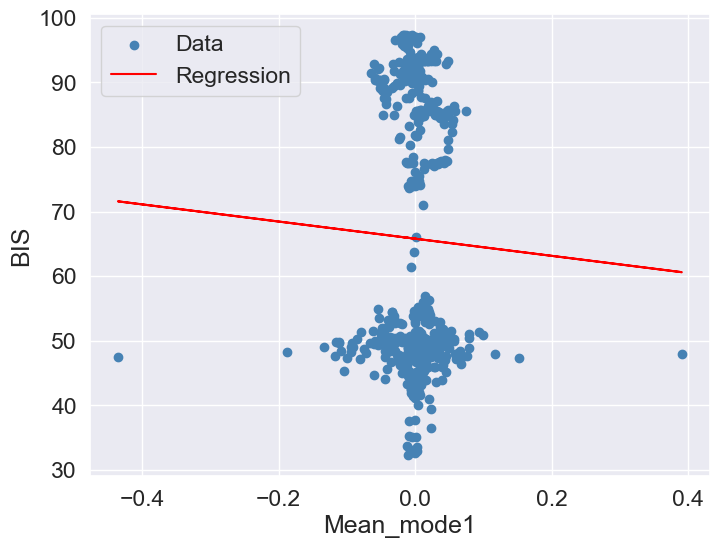

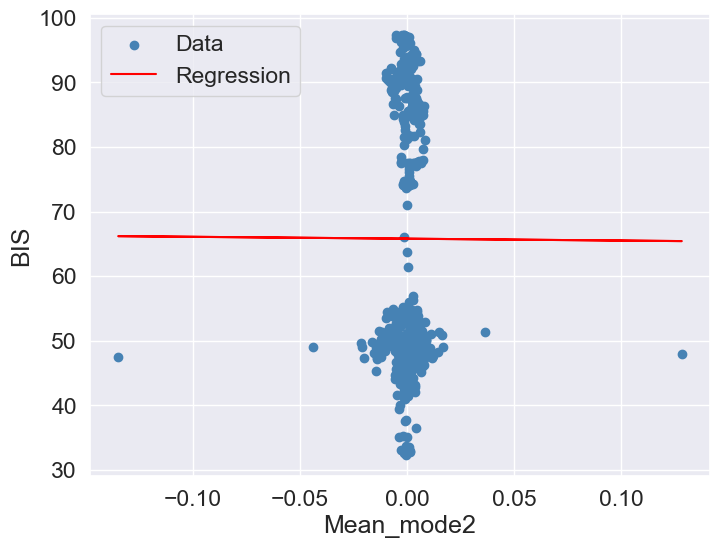

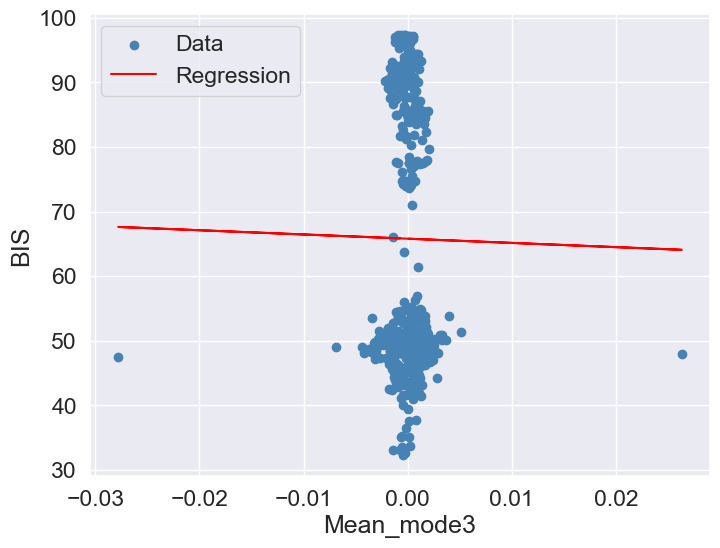

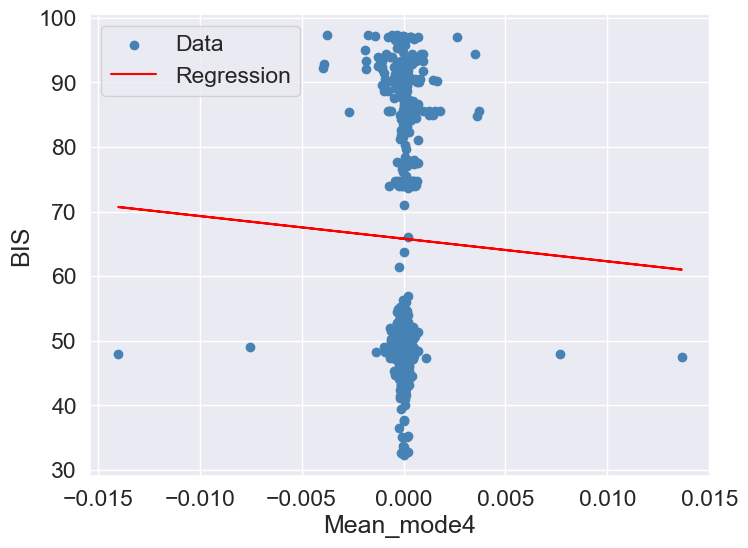

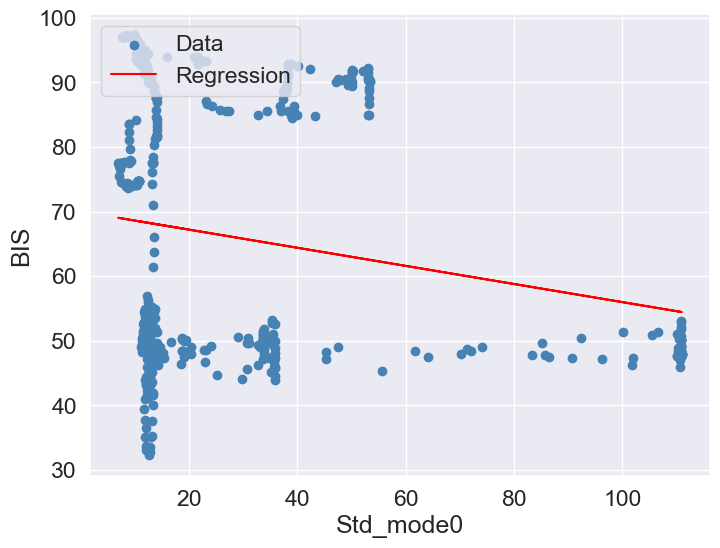

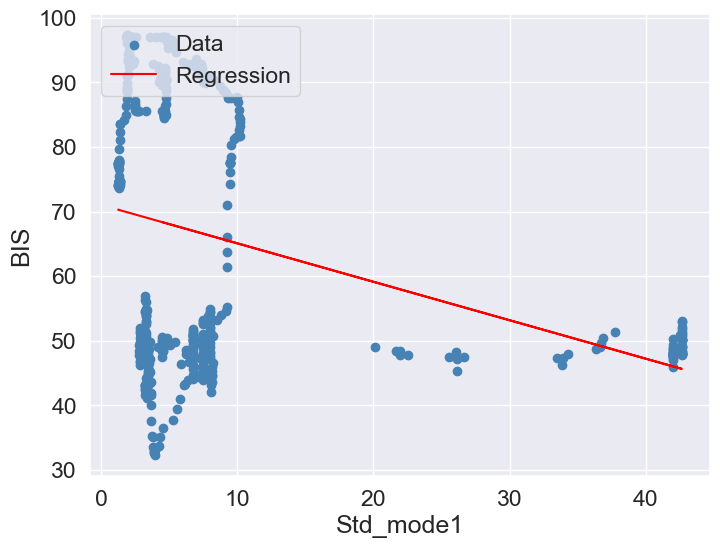

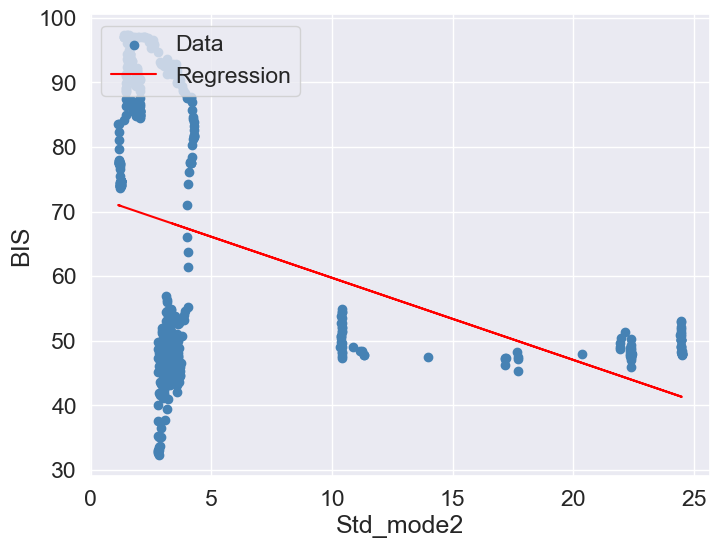

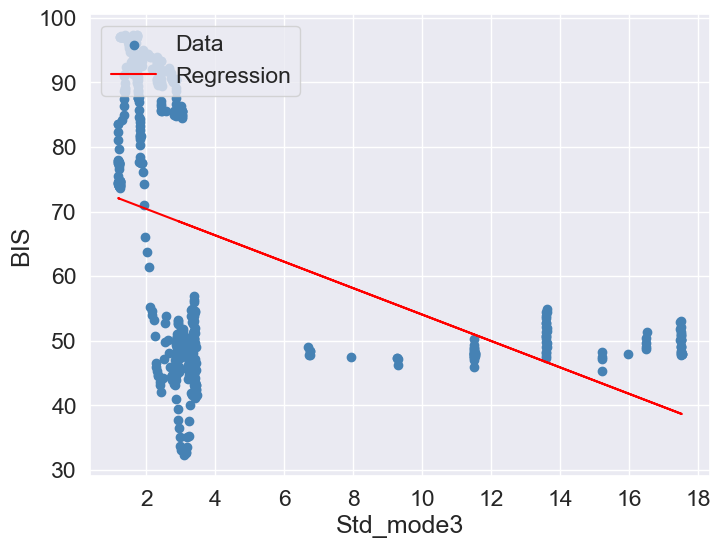

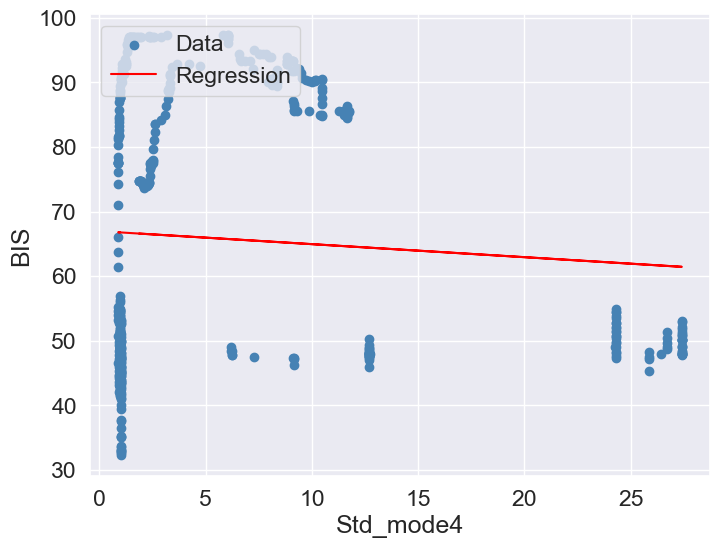

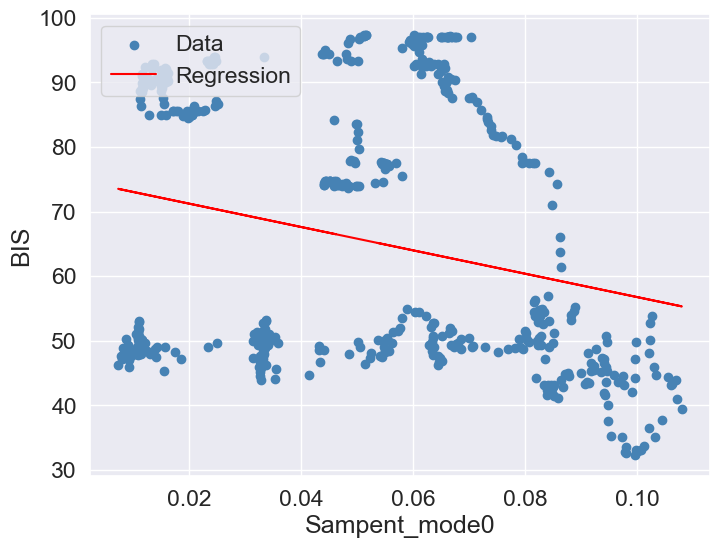

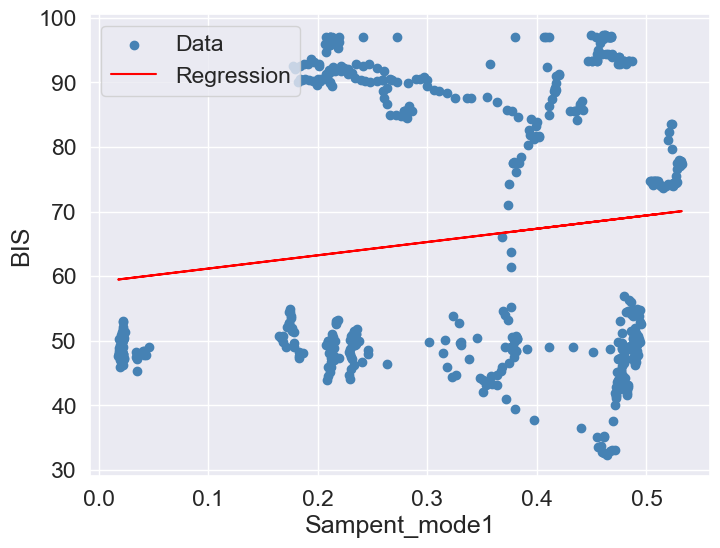

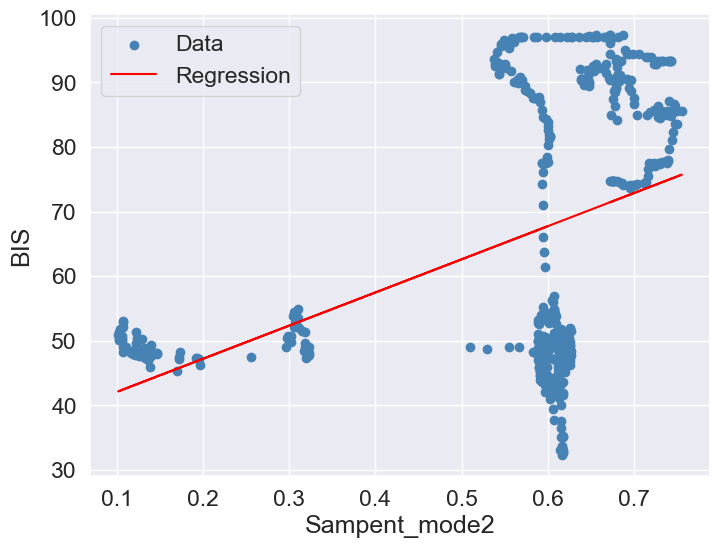

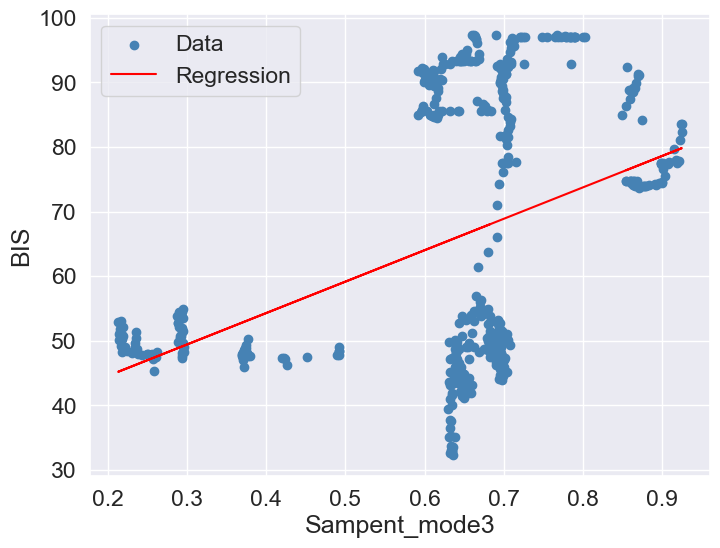

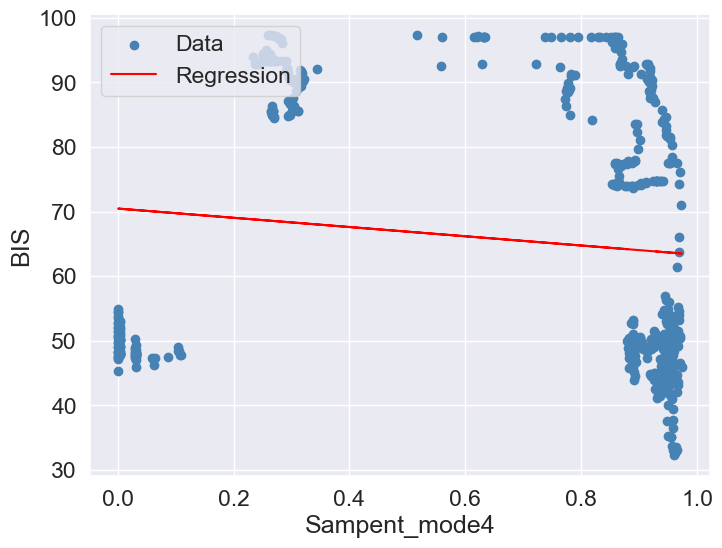

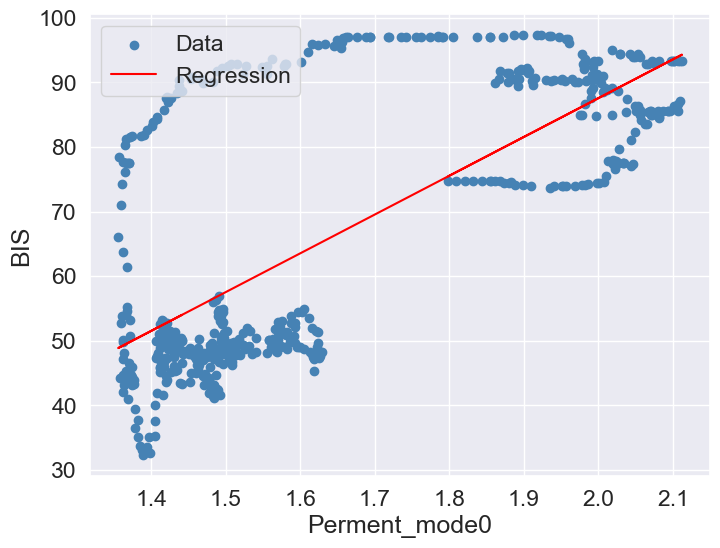

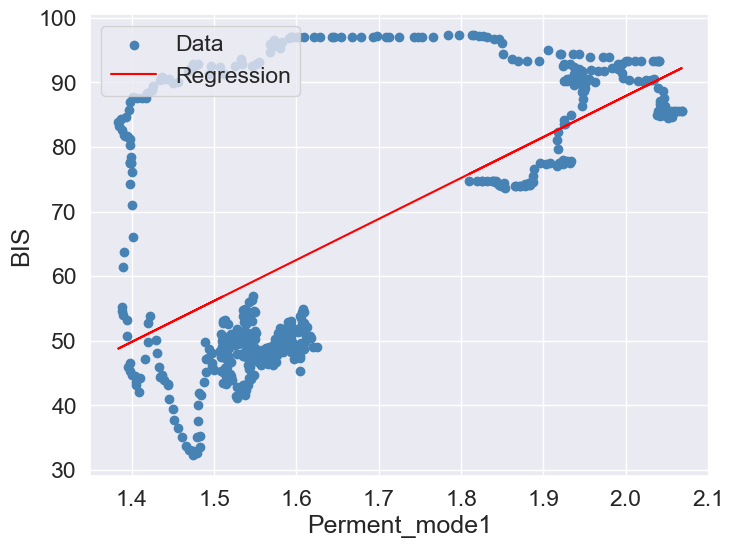

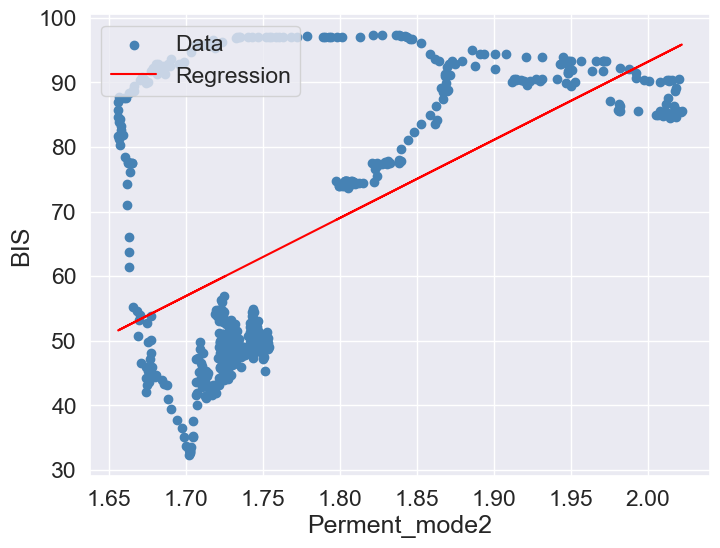

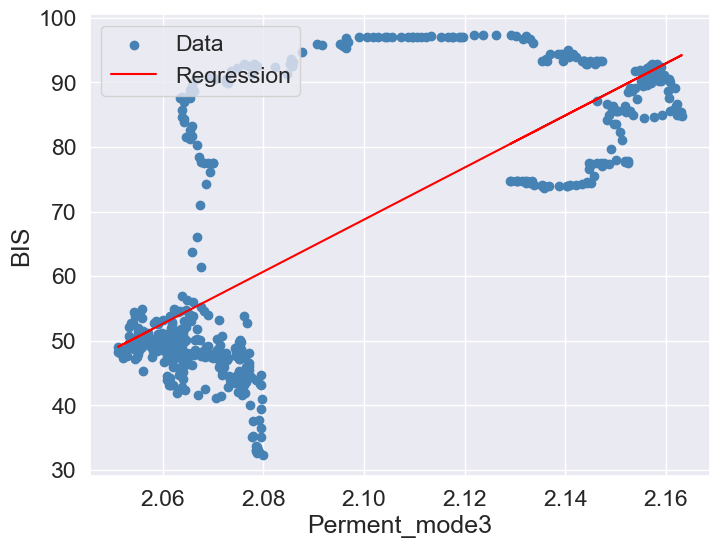

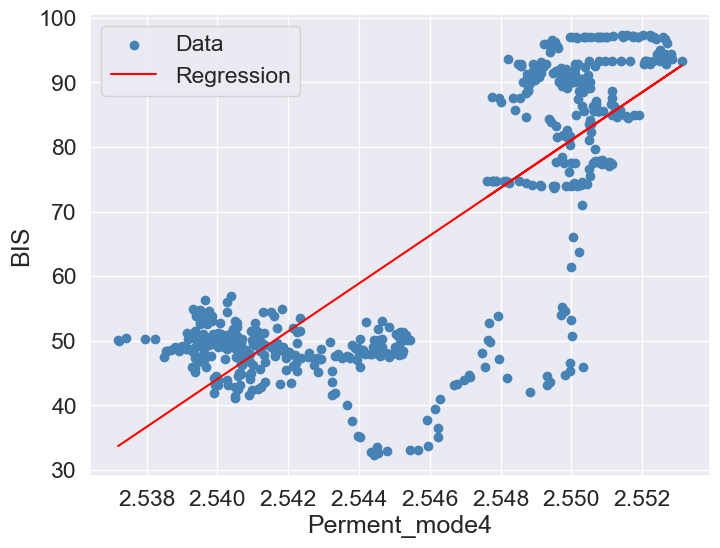

In [57]:
for column in df.columns:
    if column == "BIS":
        continue
        
    plot_regression(df, column)

In [58]:
# Metrics
res=pd.DataFrame({"R_squared": [key for key in metrics.keys()], "Values": [value*100 for value in metrics.values()]})
R=res['R_squared']
V=res["Values"]

Text(0.5, 1.0, 'R_squared')

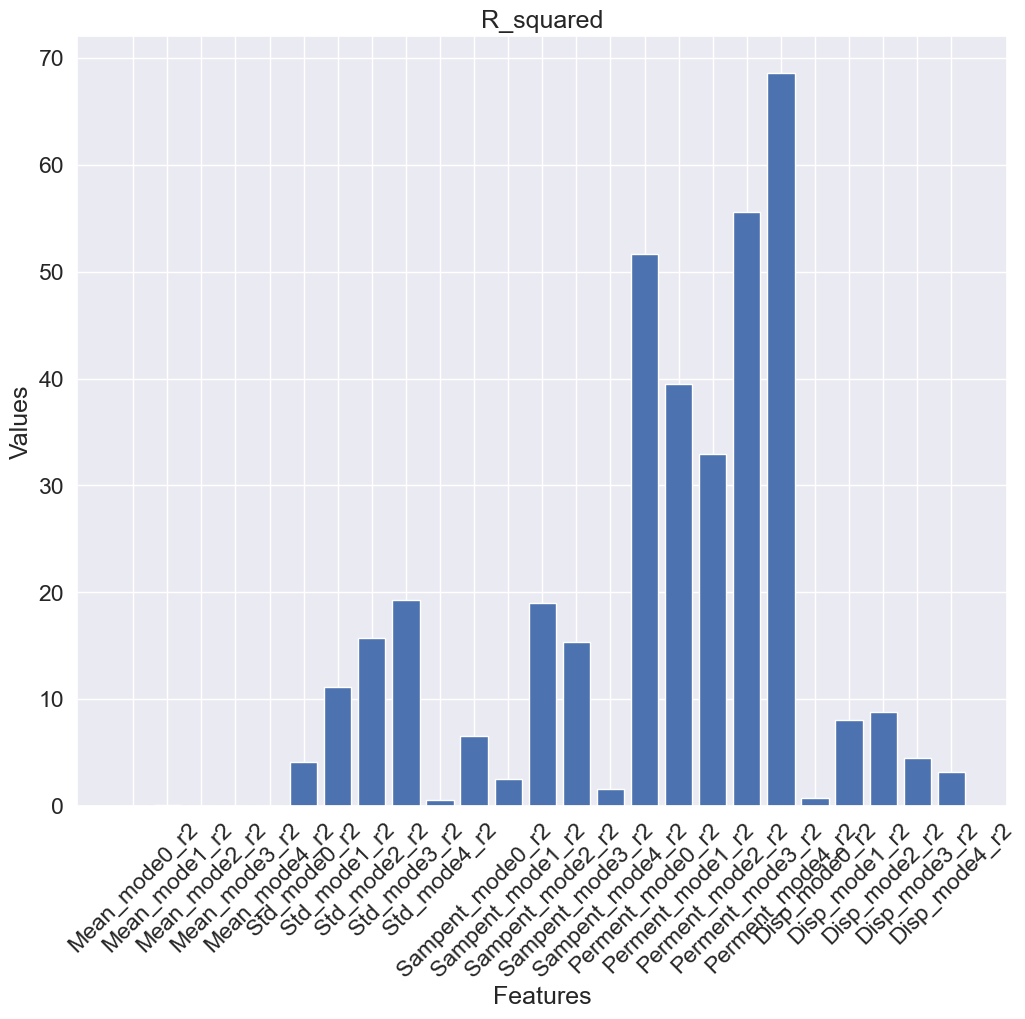

In [61]:
fig = plt.figure(figsize=(12, 10))
plt.bar(R, V)
plt.xticks(rotation=45)
plt.xlabel("Features")
plt.ylabel("Values")    
plt.title("R_squared")   

In [62]:
buk=pd.DataFrame({'Perment_mode4': resultsp_4,'Sampent_mode2': resultsa_2, 'Std_mode3': result_3})

In [64]:
combine=buk[['Perment_mode4', 'Sampent_mode2', 'Std_mode3']]
new_y=df['BIS']


mm = LinearRegression(n_jobs=-1).fit(combine, new_y)
    
# Predictions
y_pre = mm.predict(combine)
    
# Show the score and r2
mse = mean_squared_error(new_y, y_pre)
r2 = r2_score(new_y, y_pre)
    

print("Multiple regression model Slope = %s, and intercept =%s"%(mm.coef_,mm.intercept_))
print('R_Squared_value for the multiple regression model: ', r2*100)

Multiple regression model Slope = [ 3.41949131e+03  2.71884069e+00 -8.01854987e-01], and intercept =-8637.890199295724
R_Squared_value for the multiple regression model:  71.99404811356767


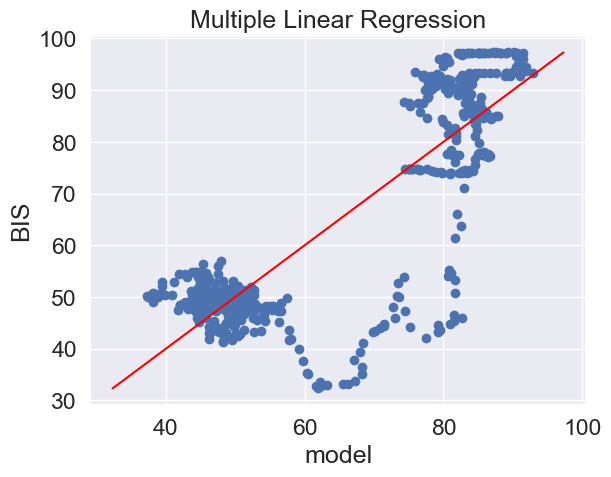

In [75]:
x1=buk['Perment_mode4']
x2=buk['Sampent_mode2']
x3=buk['Std_mode3']
y_plot =mm.coef_[0]*x1+mm.coef_[1]*x2+mm.coef_[2]*x3 + mm.intercept_

plt.scatter(y_plot, new_y)
plt.plot( [new_y.min(), new_y.max()], [new_y.min(), new_y.max()], label="Regression", c="red")

plt.title('Multiple Linear Regression')
plt.ylabel('BIS')
plt.xlabel('model')
plt.show()


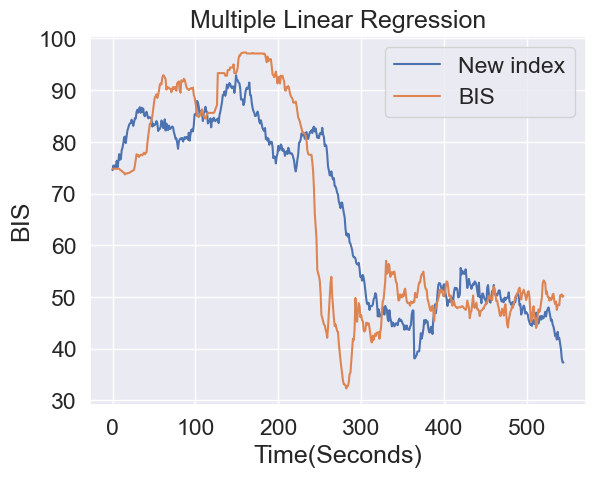

In [85]:
plt.plot(y_plot, label='New index')
plt.plot(new_y,label ="BIS")
plt.title('Multiple Linear Regression')
plt.ylabel('BIS')
plt.xlabel('Time(Seconds)')
plt.legend(loc="upper right")
plt.show()

In [ ]:
En.D